This notebook contains code for analysis of False News on Weibo (and also mentioned comparisons).

Required software/language:

Python 3.7.3

MongoDB 4.2.8

Required Python Packages:

pymongo==3.7.0

pandas==0.23.4

numpy==1.15.1

scipy=1.1.0

seaborn==0.9.0

matplotlib==3.1.0


The function plot_CCDF() partially refers to the code of (5).
The fuctions, kdeplot, _univariate_kdeplot, and _statsmodels_univariate_kde are modified based on the seaborn code.


# Imports, Settings, and Connection to MongoDB

In [1]:
# Connect to MongoDB
from pymongo import MongoClient
from bson.objectid import ObjectId
client = MongoClient('mongodb://localhost:27017')

db = client.weibo_fn
og_coll = db.orig_posts
rp_coll = db.reposts

In [54]:
# Imports
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy import integrate, signal, stats
import copy

try:
    import statsmodels.nonparametric.api as smnp
    _has_statsmodels = True
except ImportError:
    _has_statsmodels = False

In [15]:
# Figure settings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec

plt.rcParams['font.family']=['Arial']
plt.rcParams.update({'font.size': 20})

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

sns.set(rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('white')

In [4]:
def get_int(x, y):
    return integrate.trapz(y, x)

def log_10_product(x, pos):
    if x<1:
        if x>0.009:
            return '%1.2f' % (x)  #1.2f
        elif x>0.0009:
            return '%1.3f' % (x)  #1.2f
        elif x>0.00009:
            return '%1.4f' % (x)  #1.2f
    else:
        z='%1i' % (x)
        if z=='10000':
            return '10K'
        elif z=='100000':
            return '100K'
        elif z=='1000000':
            return '1000K'
        else:
            return z
        
def abs_loc(x, pos):
    return abs(x)

In [65]:
ordered_domains = ['Politics', 'Finance & Business', 'Military', 
                  'Culture & Sports & Entertainment', 'Society & Life', 
                  'Disasters & Accidents', 'Education & Examinations', 'Science & Technology',
                  'Health & Medicine']

In [66]:
domain2color ={
    'Finance & Business': 'blue',
    'Society & Life': 'orange',
    'Culture & Sports & Entertainment': 'pink',
    'Disasters & Accidents': 'red',
    'Science & Technology': 'gray',
    'Health & Medicine': 'green',
    'Education & Examinations': 'cyan',
    'Politics': 'brown',
    'Military': 'olive'
}

# Domain-level Distribution (Fig. 1, Table 11, Section 3.4)

In [7]:
# The Twitter Data from Vosoughi et al [69].
domain_dist_tw ={
    'Politics': 27600,
    'Society & Life': 16458,
    'Science & Technology': 12043,
    'Finance & Business': 11086,
    'Military': 8054,
    'Culture & Sports & Entertainment': 6046,
    'Disasters & Accidents': 1318,
    'Health & Medicine': 0,
    'Education & Examinations': 0
}

In [10]:
og_coll.update_many({},{'$rename': { "topic": "domain" }})

In [57]:
# The Weibo data.
domain_dist_wb = {}

for domain in domain_dist_tw.keys():
    domain_dist_wb[domain] = og_coll.count_documents({'domain':domain})

domain_dist_wb

{'Politics': 2560,
 'Society & Life': 16003,
 'Science & Technology': 2302,
 'Finance & Business': 3402,
 'Military': 765,
 'Culture & Sports & Entertainment': 3866,
 'Disasters & Accidents': 4515,
 'Health & Medicine': 7788,
 'Education & Examinations': 3527}

In [58]:
# Spearman's rho in Section 3.4

# Nine domains
print('9 domains:', spearmanr(list(domain_dist_tw.values()), 
                             list(domain_dist_wb.values())))

# Seven domains (excluding Health & Medicine and Education & Examincations)
print('7 domains:', spearmanr(list(domain_dist_tw.values())[:7], 
                             list(domain_dist_wb.values())[:7]))

# merge Health & Medicine into Science & Technology, 
# and Education & Examinations into Society & Life for alignment
domain_dist_wb_merged = copy.deepcopy(domain_dist_wb)
domain_dist_wb_merged['Science & Technology'] += domain_dist_wb_merged['Health & Medicine']
domain_dist_wb_merged['Society & Life'] += domain_dist_wb_merged['Education & Examinations']
print('after merging:', spearmanr(list(domain_dist_tw.values())[:7], 
                                  list(domain_dist_wb.values())[:7]))


9 domains: SpearmanrResult(correlation=-0.3096261412396175, pvalue=0.4174779170120546)
7 domains: SpearmanrResult(correlation=-0.14285714285714288, pvalue=0.7599453002180929)
after merging: SpearmanrResult(correlation=-0.14285714285714288, pvalue=0.7599453002180929)


In [59]:
# Data for Fig. 1 and Table 11.
total_wb = sum(domain_dist_wb.values())
total_tw = sum(domain_dist_tw.values())

domain_dists  = [{'Domain':domain, 
                 'Platform':'Twitter',
                 'N':domain_dist_tw[domain], 
                 '%':domain_dist_tw[domain] / total_tw}
                for domain in domain_dist_tw.keys()]

domain_dists2 = [{'Domain':domain, 
                 'Platform':'Weibo',
                 'N':domain_dist_wb[domain], 
                 '%':domain_dist_wb[domain] / total_wb}
                for domain in domain_dist_tw.keys()]

domain_dists.extend(domain_dists2)
domain_dists = pd.DataFrame(domain_dists)
domain_dists = domain_dists[['Domain', 'Platform', 'N', '%']]
domain_dists 

Domain Platform      N         %
0                           Politics  Twitter  27600  0.334120
1                     Society & Life  Twitter  16458  0.199237
2               Science & Technology  Twitter  12043  0.145790
3                 Finance & Business  Twitter  11086  0.134205
4                           Military  Twitter   8054  0.097500
5   Culture & Sports & Entertainment  Twitter   6046  0.073192
6              Disasters & Accidents  Twitter   1318  0.015955
7                  Health & Medicine  Twitter      0  0.000000
8           Education & Examinations  Twitter      0  0.000000
9                           Politics    Weibo   2560  0.057235
10                    Society & Life    Weibo  16003  0.357785
11              Science & Technology    Weibo   2302  0.051467
12                Finance & Business    Weibo   3402  0.076060
13                          Military    Weibo    765  0.017103
14  Culture & Sports & Entertainment    Weibo   3866  0.086434
15             Disasters & Accidents    Weibo   4515  0.100943
16                 Health & Medicine    Weibo   7788  0.174119
17          Education & Examinations    Weibo   3527  0.078854

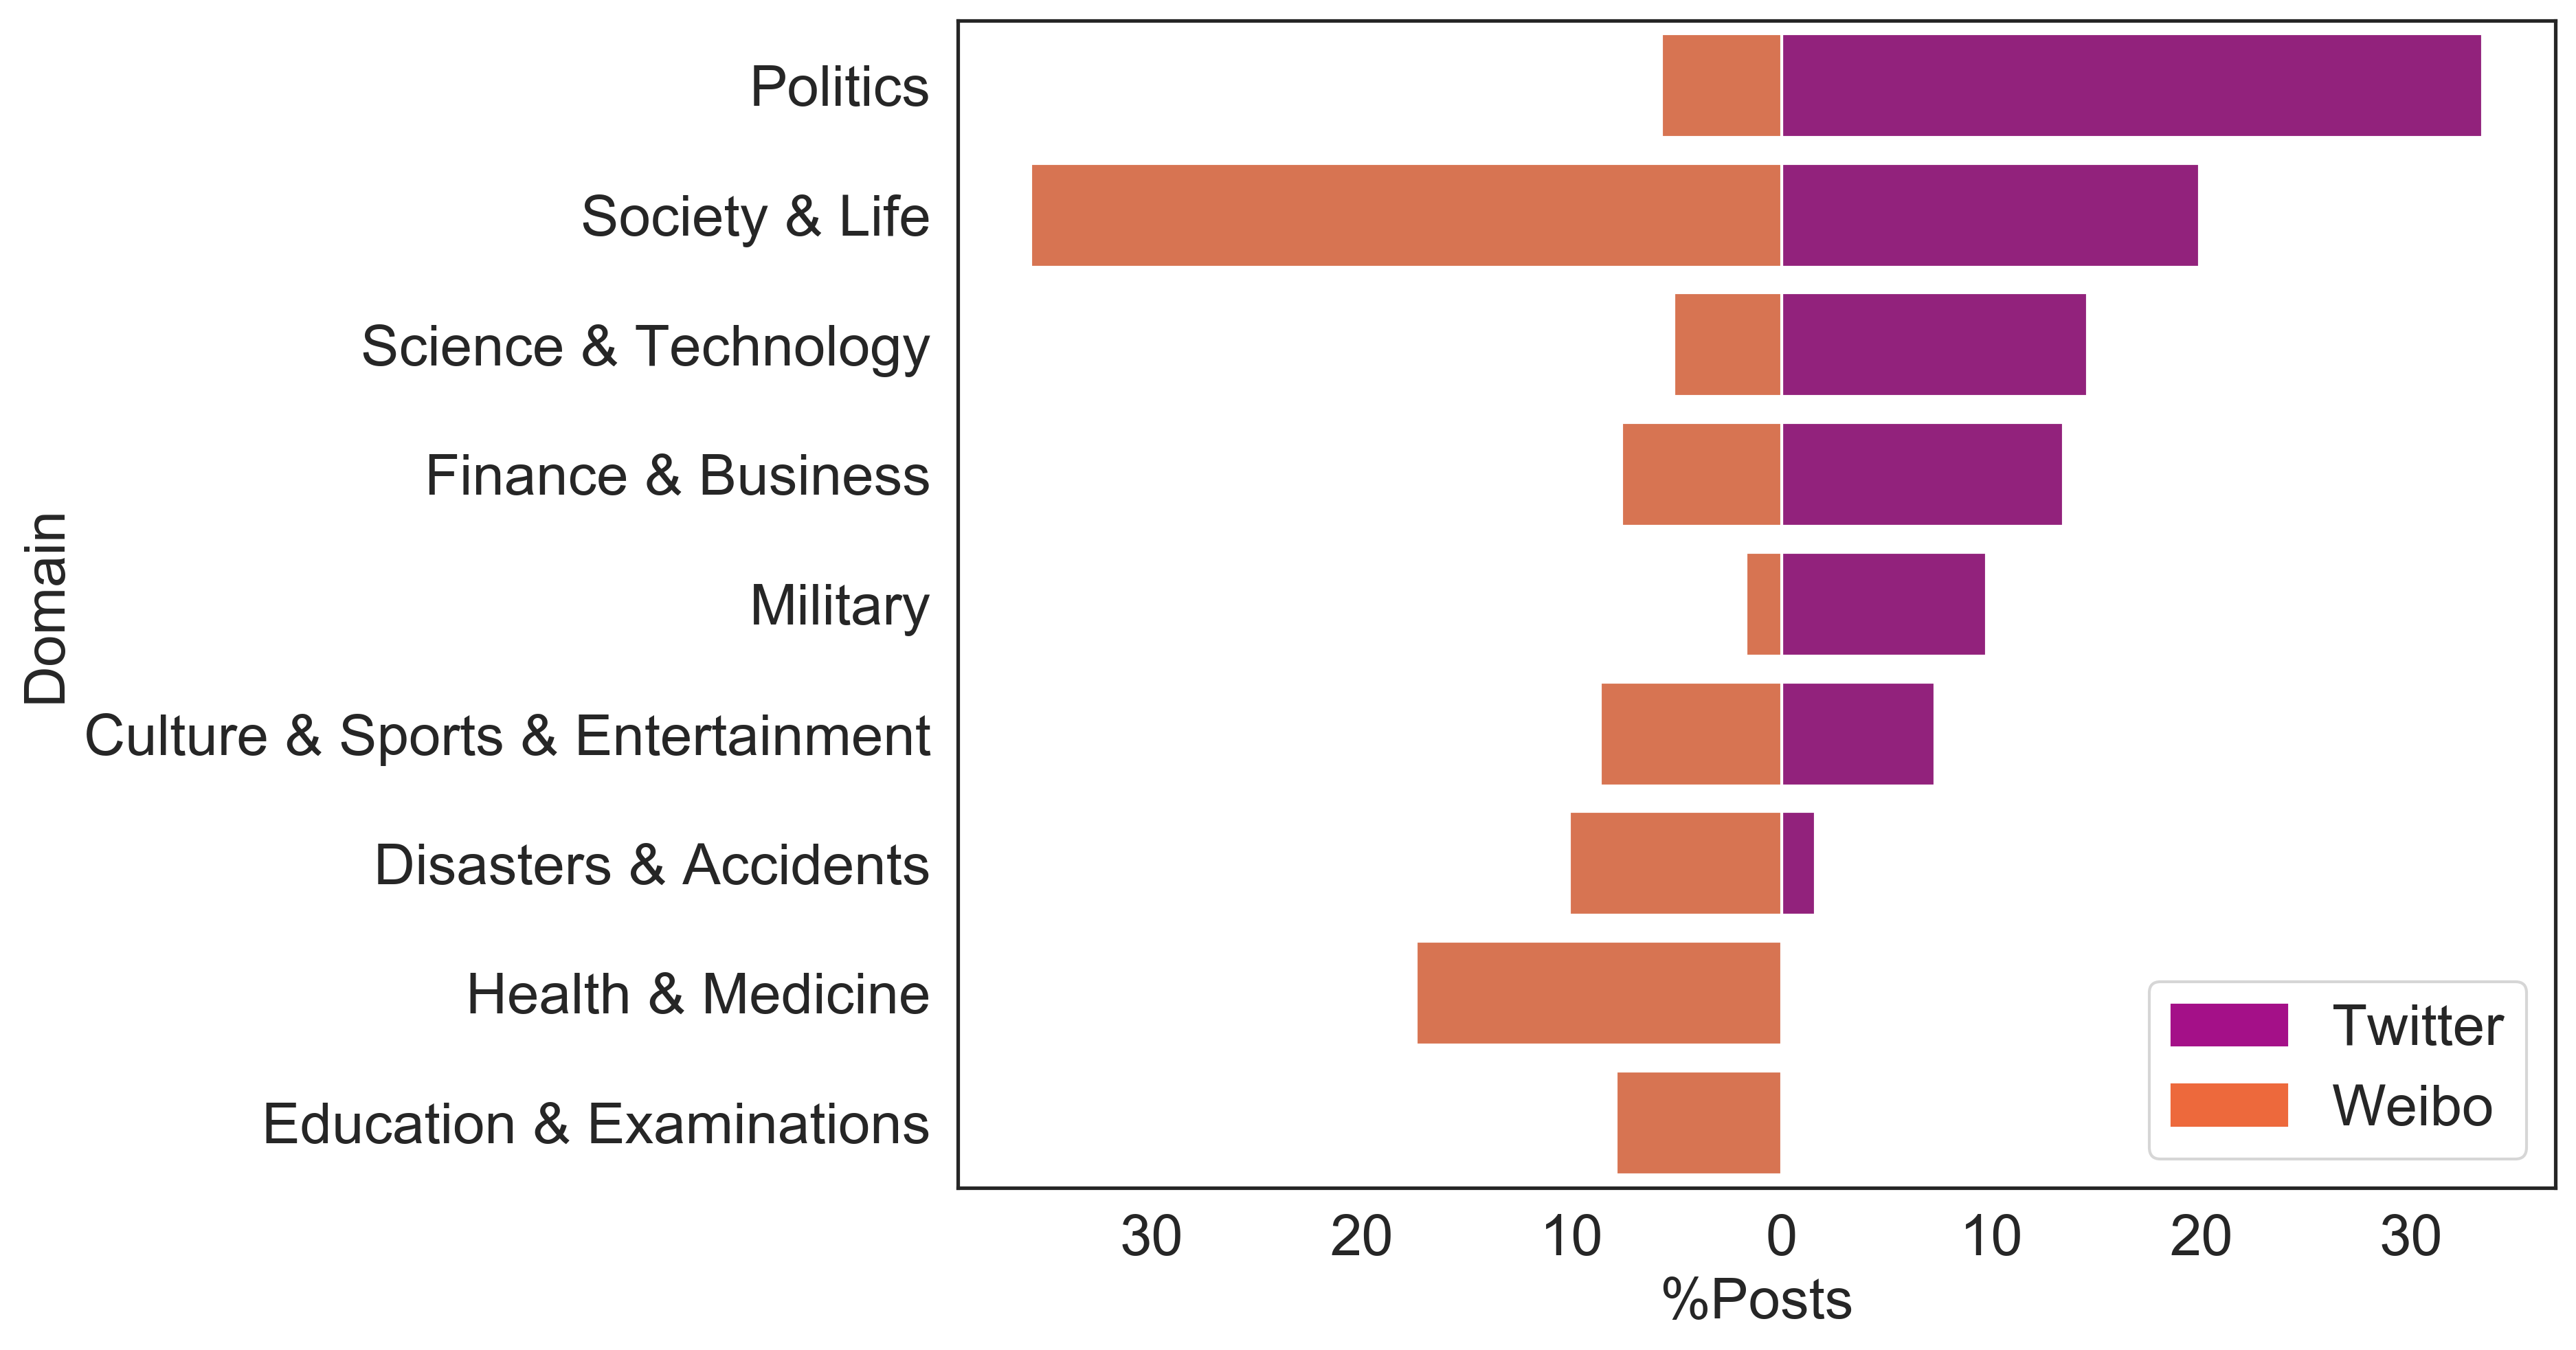

In [60]:
# Fig. 1
fig, ax = plt.subplots(figsize = (10,7.5))    

bplt = sns.barplot(y = domain_dists['Domain'], x = domain_dists[domain_dists['Platform'] == 'Twitter']['%'] * 100, \
                       data = domain_dists, orient = "h", color = '#A41088', ax = ax)

bplt2 = sns.barplot(y = domain_dists['Domain'], x = domain_dists[domain_dists['Platform'] == 'Weibo']['%'] * -100,
                   data = domain_dists, orient = "h", color = '#ED693C')

bplt.set_xlabel("%Posts", fontsize = 20)
bplt.set_ylabel("Domain", fontsize = 20)
bplt.set_yticklabels(domain_dists['Domain'], rotation = 0, fontsize = 20)

t_patch = mpatches.Patch(color='#A41088', label='Twitter')
w_patch = mpatches.Patch(color='#ED693C', label='Weibo')
plt.legend(handles=[t_patch, w_patch], loc=4, ncol = 1, prop={'size':20})


# for i, d in enumerate(domain_dists['Domain']):
#     p = float(domain_dists[(domain_dists['Platform'] == 'Twitter') & (domain_dists['Domain'] == d)]['%'] * 100)
#     N = int(domain_dists[(domain_dists['Platform'] == 'Twitter') & (domain_dists['Domain'] == d)]['N'])
#     bplt.text(p+0.5, i+0.15, N, fontsize = 15)
#     p = float(domain_dists[(domain_dists['Platform'] == 'Weibo') & (domain_dists['Domain'] == d)]['%'] * 100)
#     N = int(domain_dists[(domain_dists['Platform'] == 'Weibo') & (domain_dists['Domain'] == d)]['N'])
#     bplt2.text(p-3, i+0.15, N, fontsize = 15)
    
formatter = plt.FuncFormatter(abs_loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_ticklabels([40, 30, 20, 10, 0, 10, 20, 30, 40], fontsize=20)
plt.savefig('./figs/fig_1.pdf', bbox_inches='tight', format='pdf')

# Diffusion (Section 4)

In [61]:
ints = {
    'Size':{},
    'Maximum Depth':{},
    'Maximum Breadth':{},
    'Number of Engaged Users':{}
}

In [72]:
def measure_stat(measure_name):
    data = {domain:[] for domain in ordered_domains}
    
    for og in og_coll.find({}):
        data[og['domain']].append(int(og[measure_name]))

    data_stat = []
#     for k, v in data.items():
#         data_stat.append({
#             'Domain': k,
#             'Mean': np.average(v),
#             'Standard Error': np.std(v),
#             'Min': np.min(v),
#             'Median': int(np.median(v)),
#             'Max': np.max(v)
#         })

#     data_stat = pd.DataFrame(data_stat)
#     data_stat = data_stat[['Domain', 'Mean', 'Standard Error', 'Min', 'Median', 'Max']]
#     return data, data_stat
    return data

In [71]:
def plot_CCDF(data, measure_name, output_path):
    ax = plt.subplot(111)
    ax.set_xscale('log')
    ax.set_yscale('log')
    formatter = plt.FuncFormatter(log_10_product)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    legends = []
    for domain, v in data.items():
        total=float(len(v))
        xf = []
        pf = []
        v.sort()
        counts = list(set(v))
        counts.sort()
        for d in counts:
            ind = v.index(d)
            count = len(v[ind:])
            p = (count / float(total)) * 100
            xf.append(d)
            pf.append(p)
        ax.plot(xf, pf, '-',color = domain2color[domain], linewidth = 1.5)
        try:
            ints[measure_name][domain] = get_int(xf, pf)
        except:
            pass
        legends.append(domain)
    plt.xlabel(measure_name,fontsize=20)
    plt.ylabel("CCDF (%)",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.xticks(rotation='horizontal')
    plt.legend(legends,loc='lower left',fontsize=15,frameon=False)
    plt.xlim(xmin=1)
    plt.ylim(ymax=100)
    plt.savefig(output_path, bbox_inches='tight', format='pdf')
    plt.figure()

## Size (Fig. 2(a))

In [73]:
sizes = measure_stat('size')

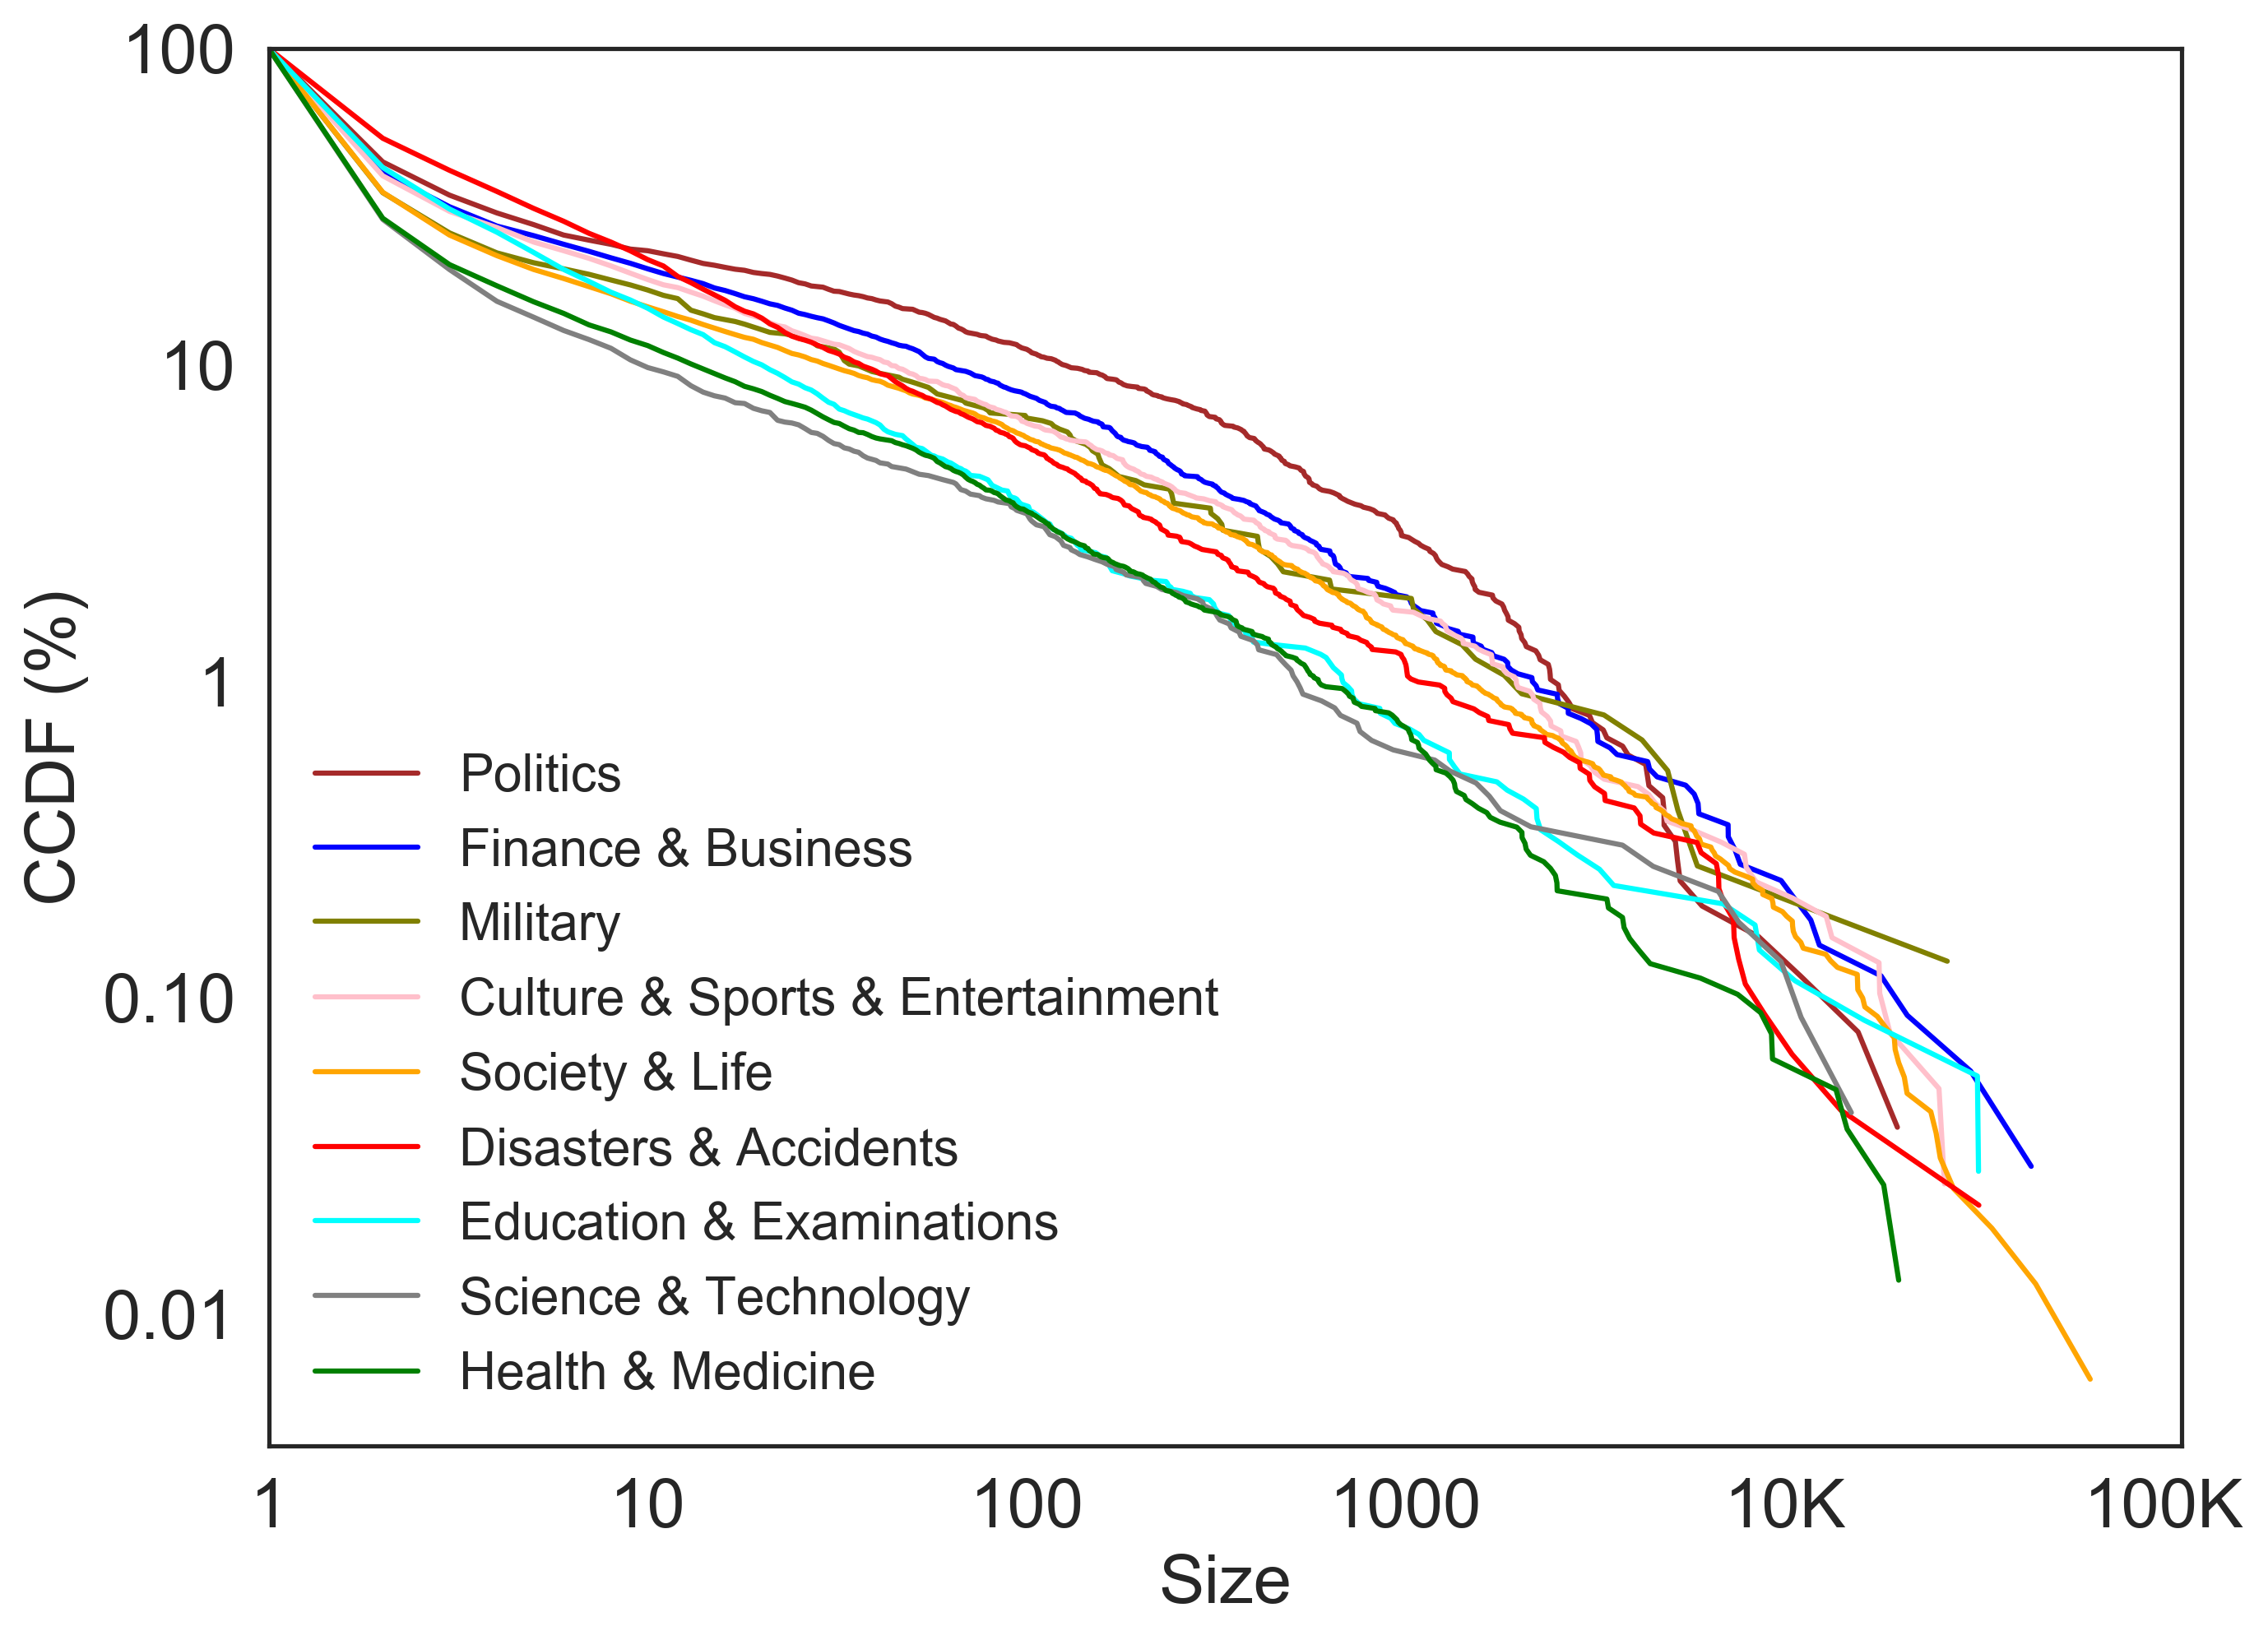

<Figure size 3000x2250 with 0 Axes>

In [74]:
plot_CCDF(sizes, 'Size', './figs/fig_2A.pdf')

## Maximum Depth (Fig. 2B)

In [75]:
max_depths = measure_stat('max_depth')

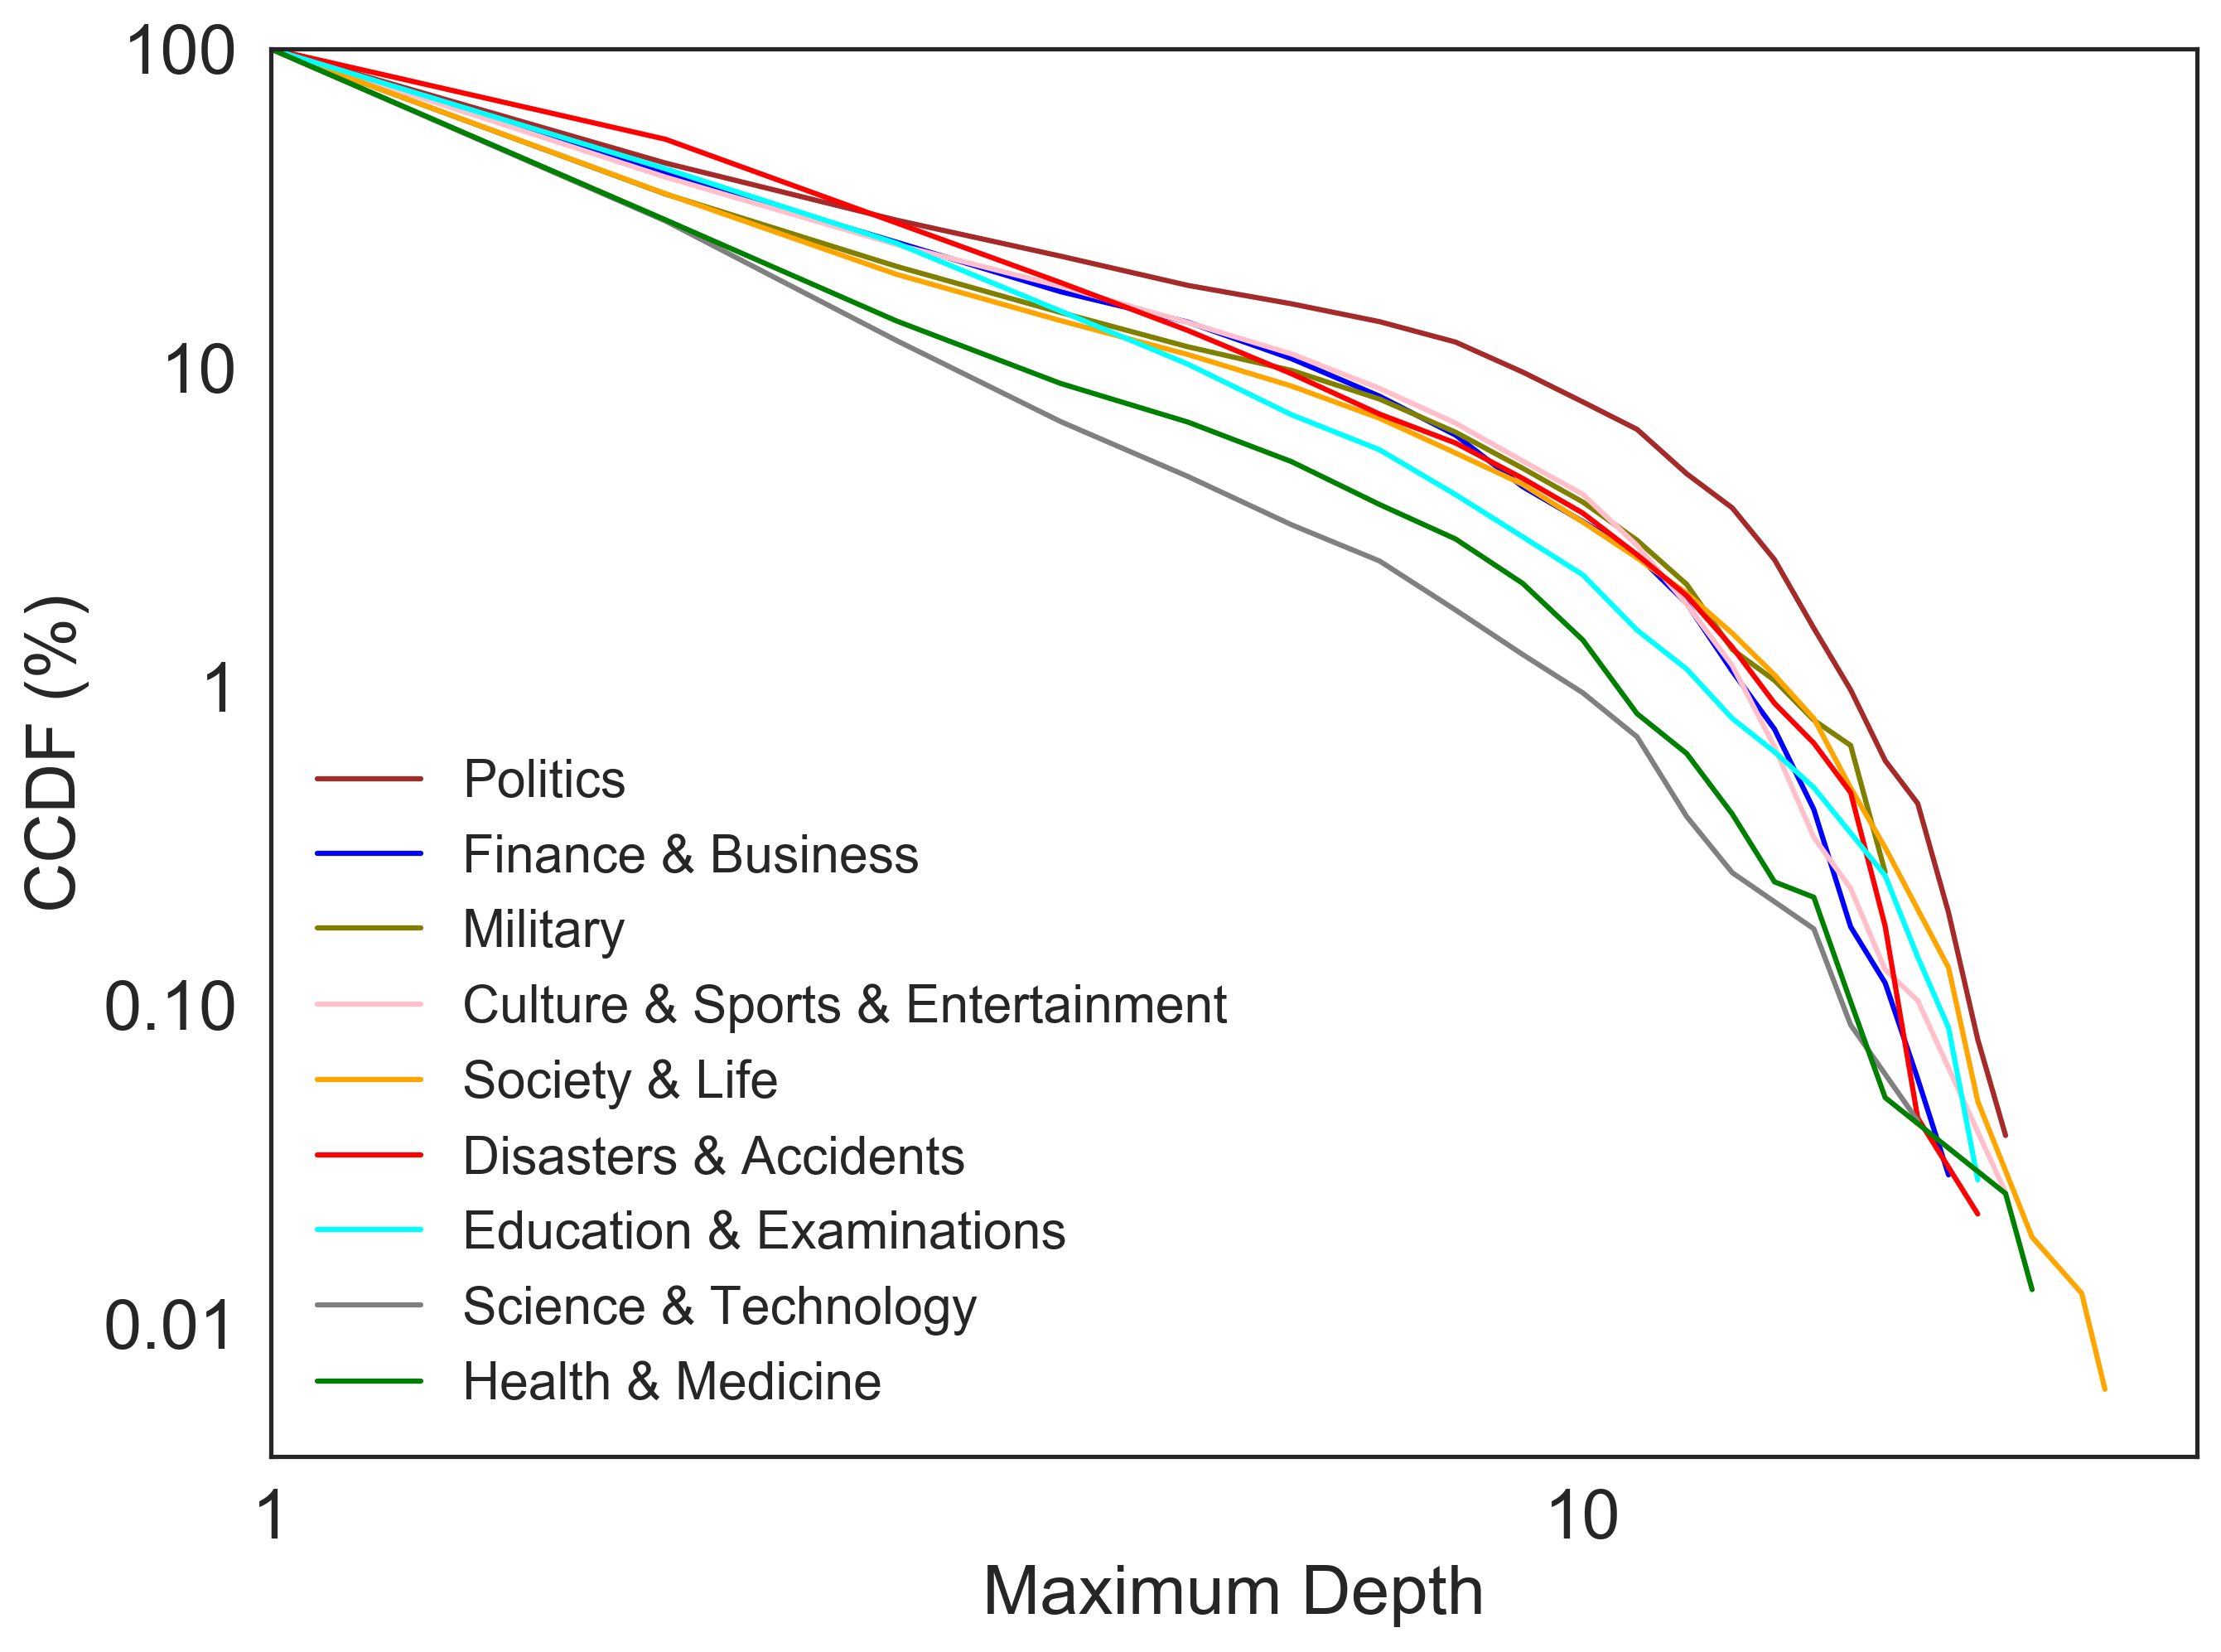

<Figure size 3000x2250 with 0 Axes>

In [76]:
plot_CCDF(max_depths, 'Maximum Depth', './figs/fig_2B.pdf')

## Maximum Breadth (Fig. 2C)

In [77]:
max_breadths = measure_stat('max_breadth')

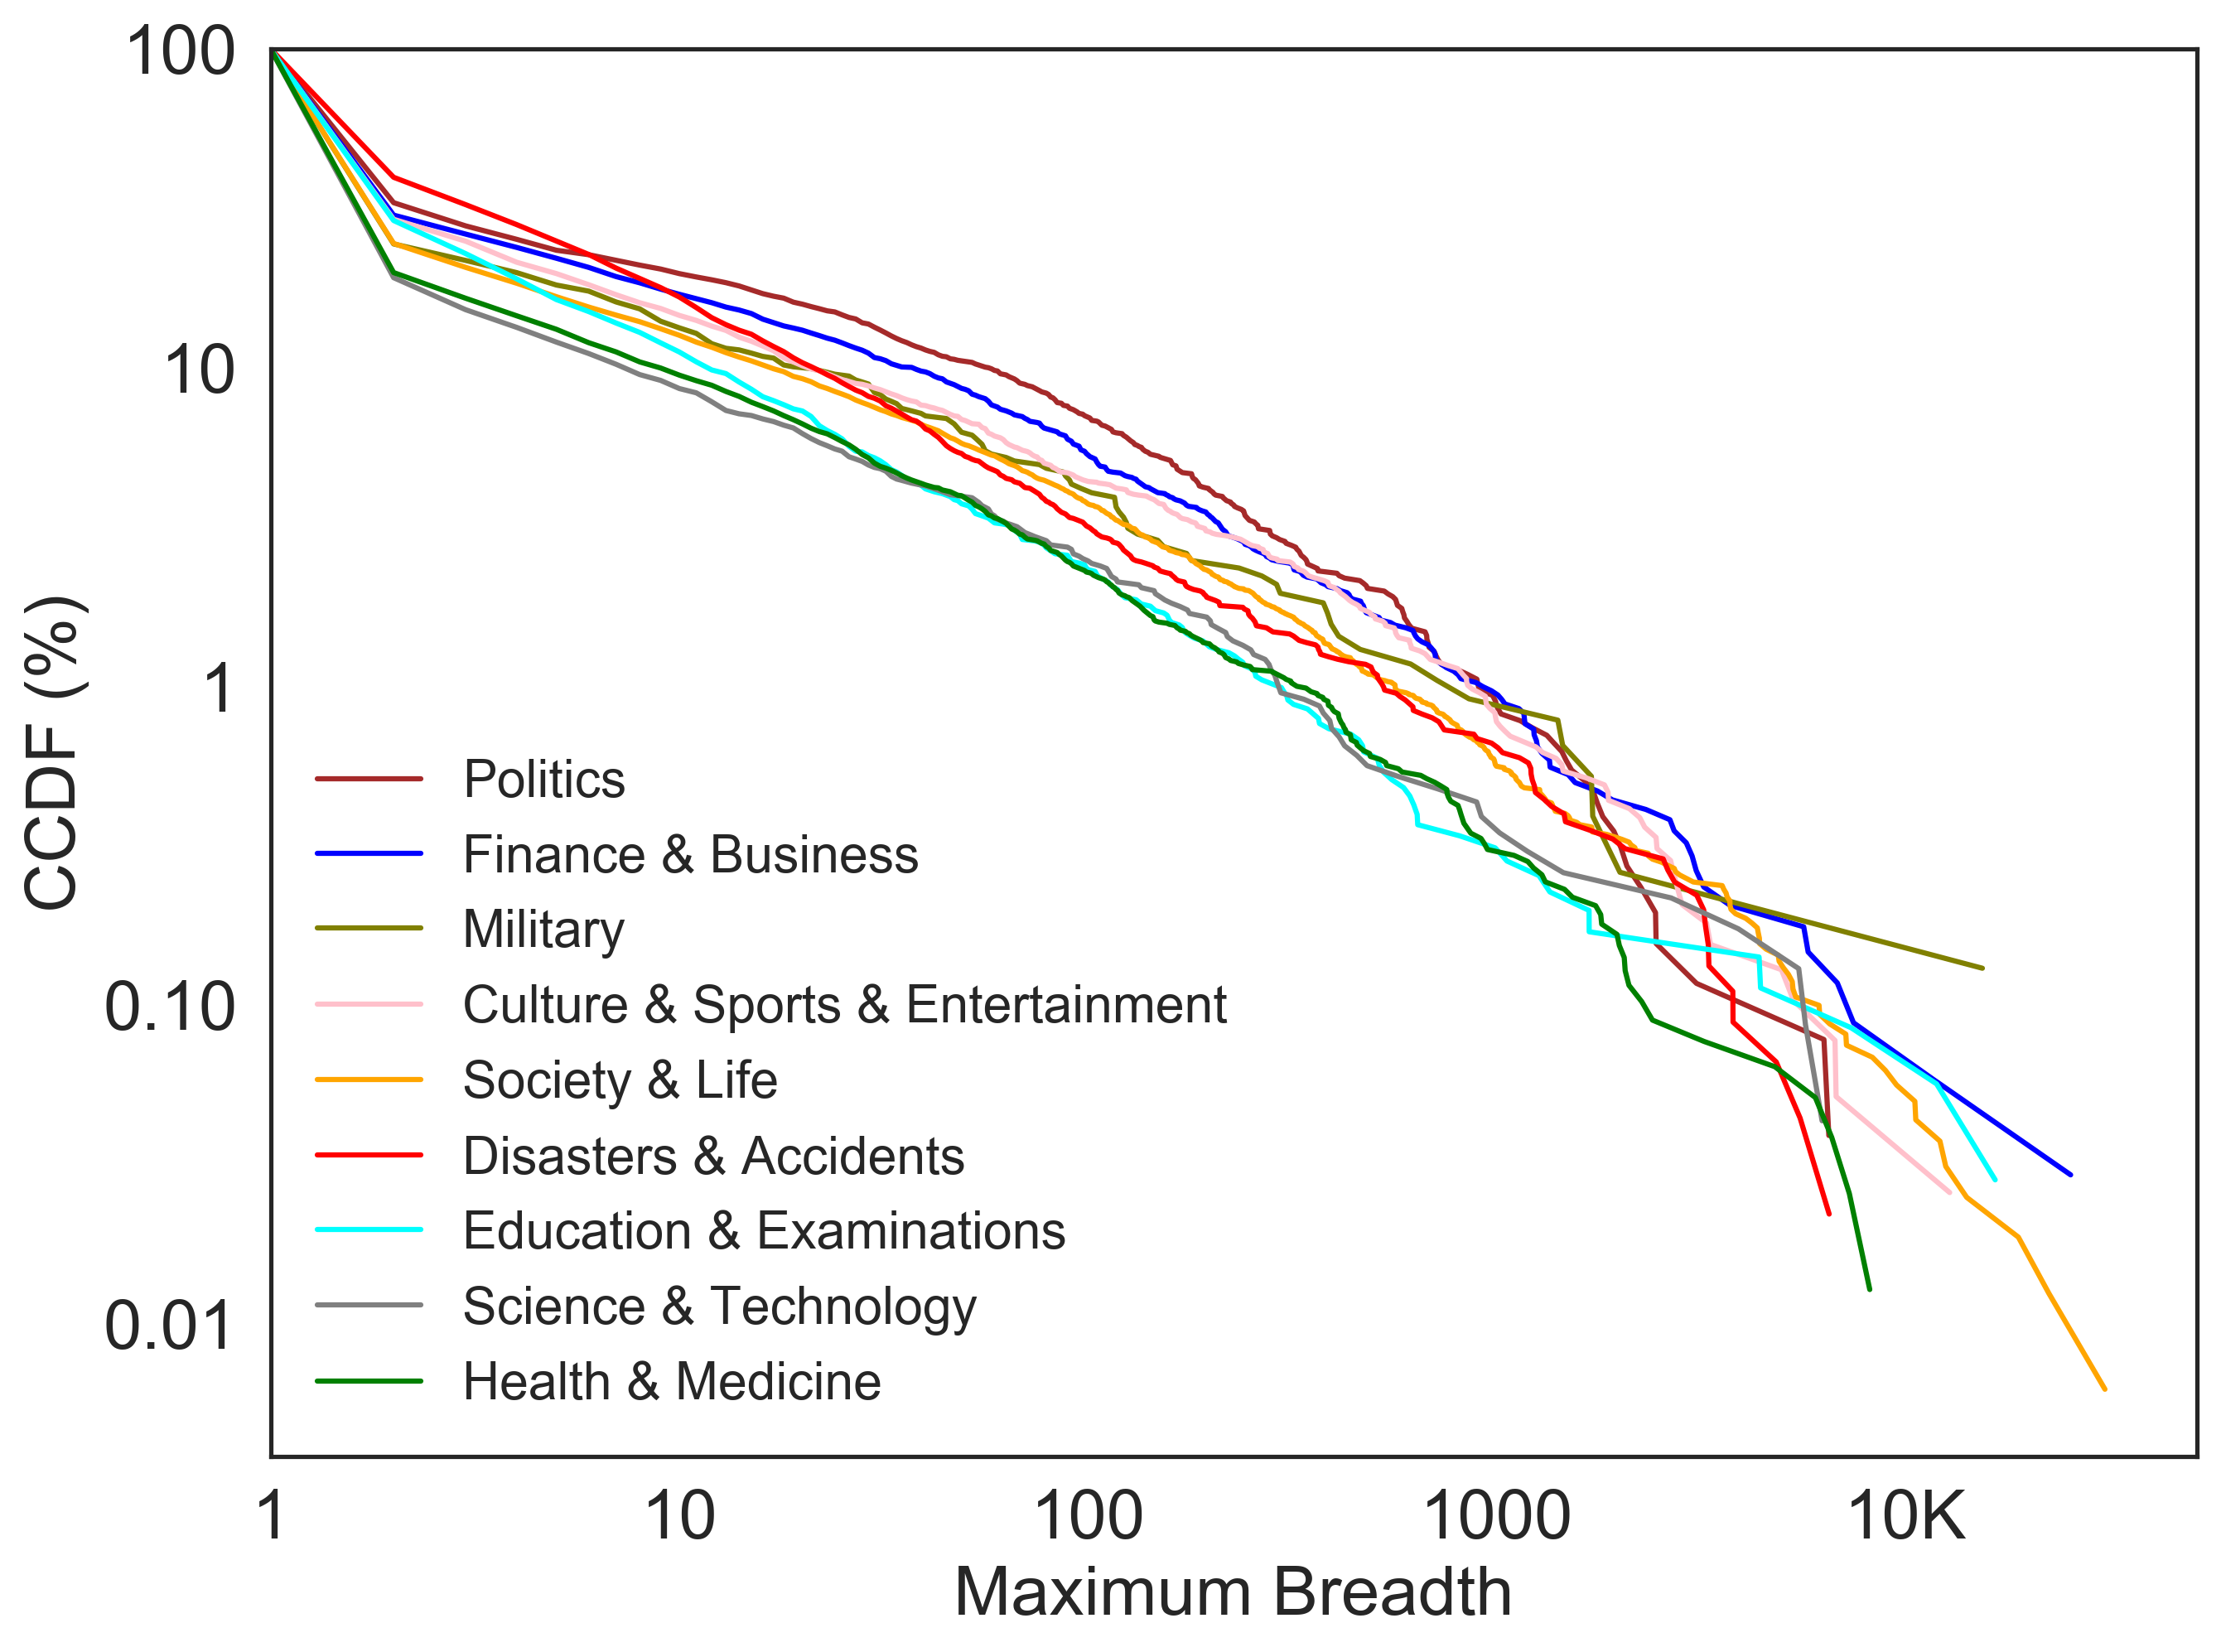

<Figure size 3000x2250 with 0 Axes>

In [78]:
plot_CCDF(max_breadths, 'Maximum Breadth', './figs/fig_2C.pdf')

## Number of Engaged Users (Fig. 2D)

In [79]:
neu = measure_stat('unique_user')

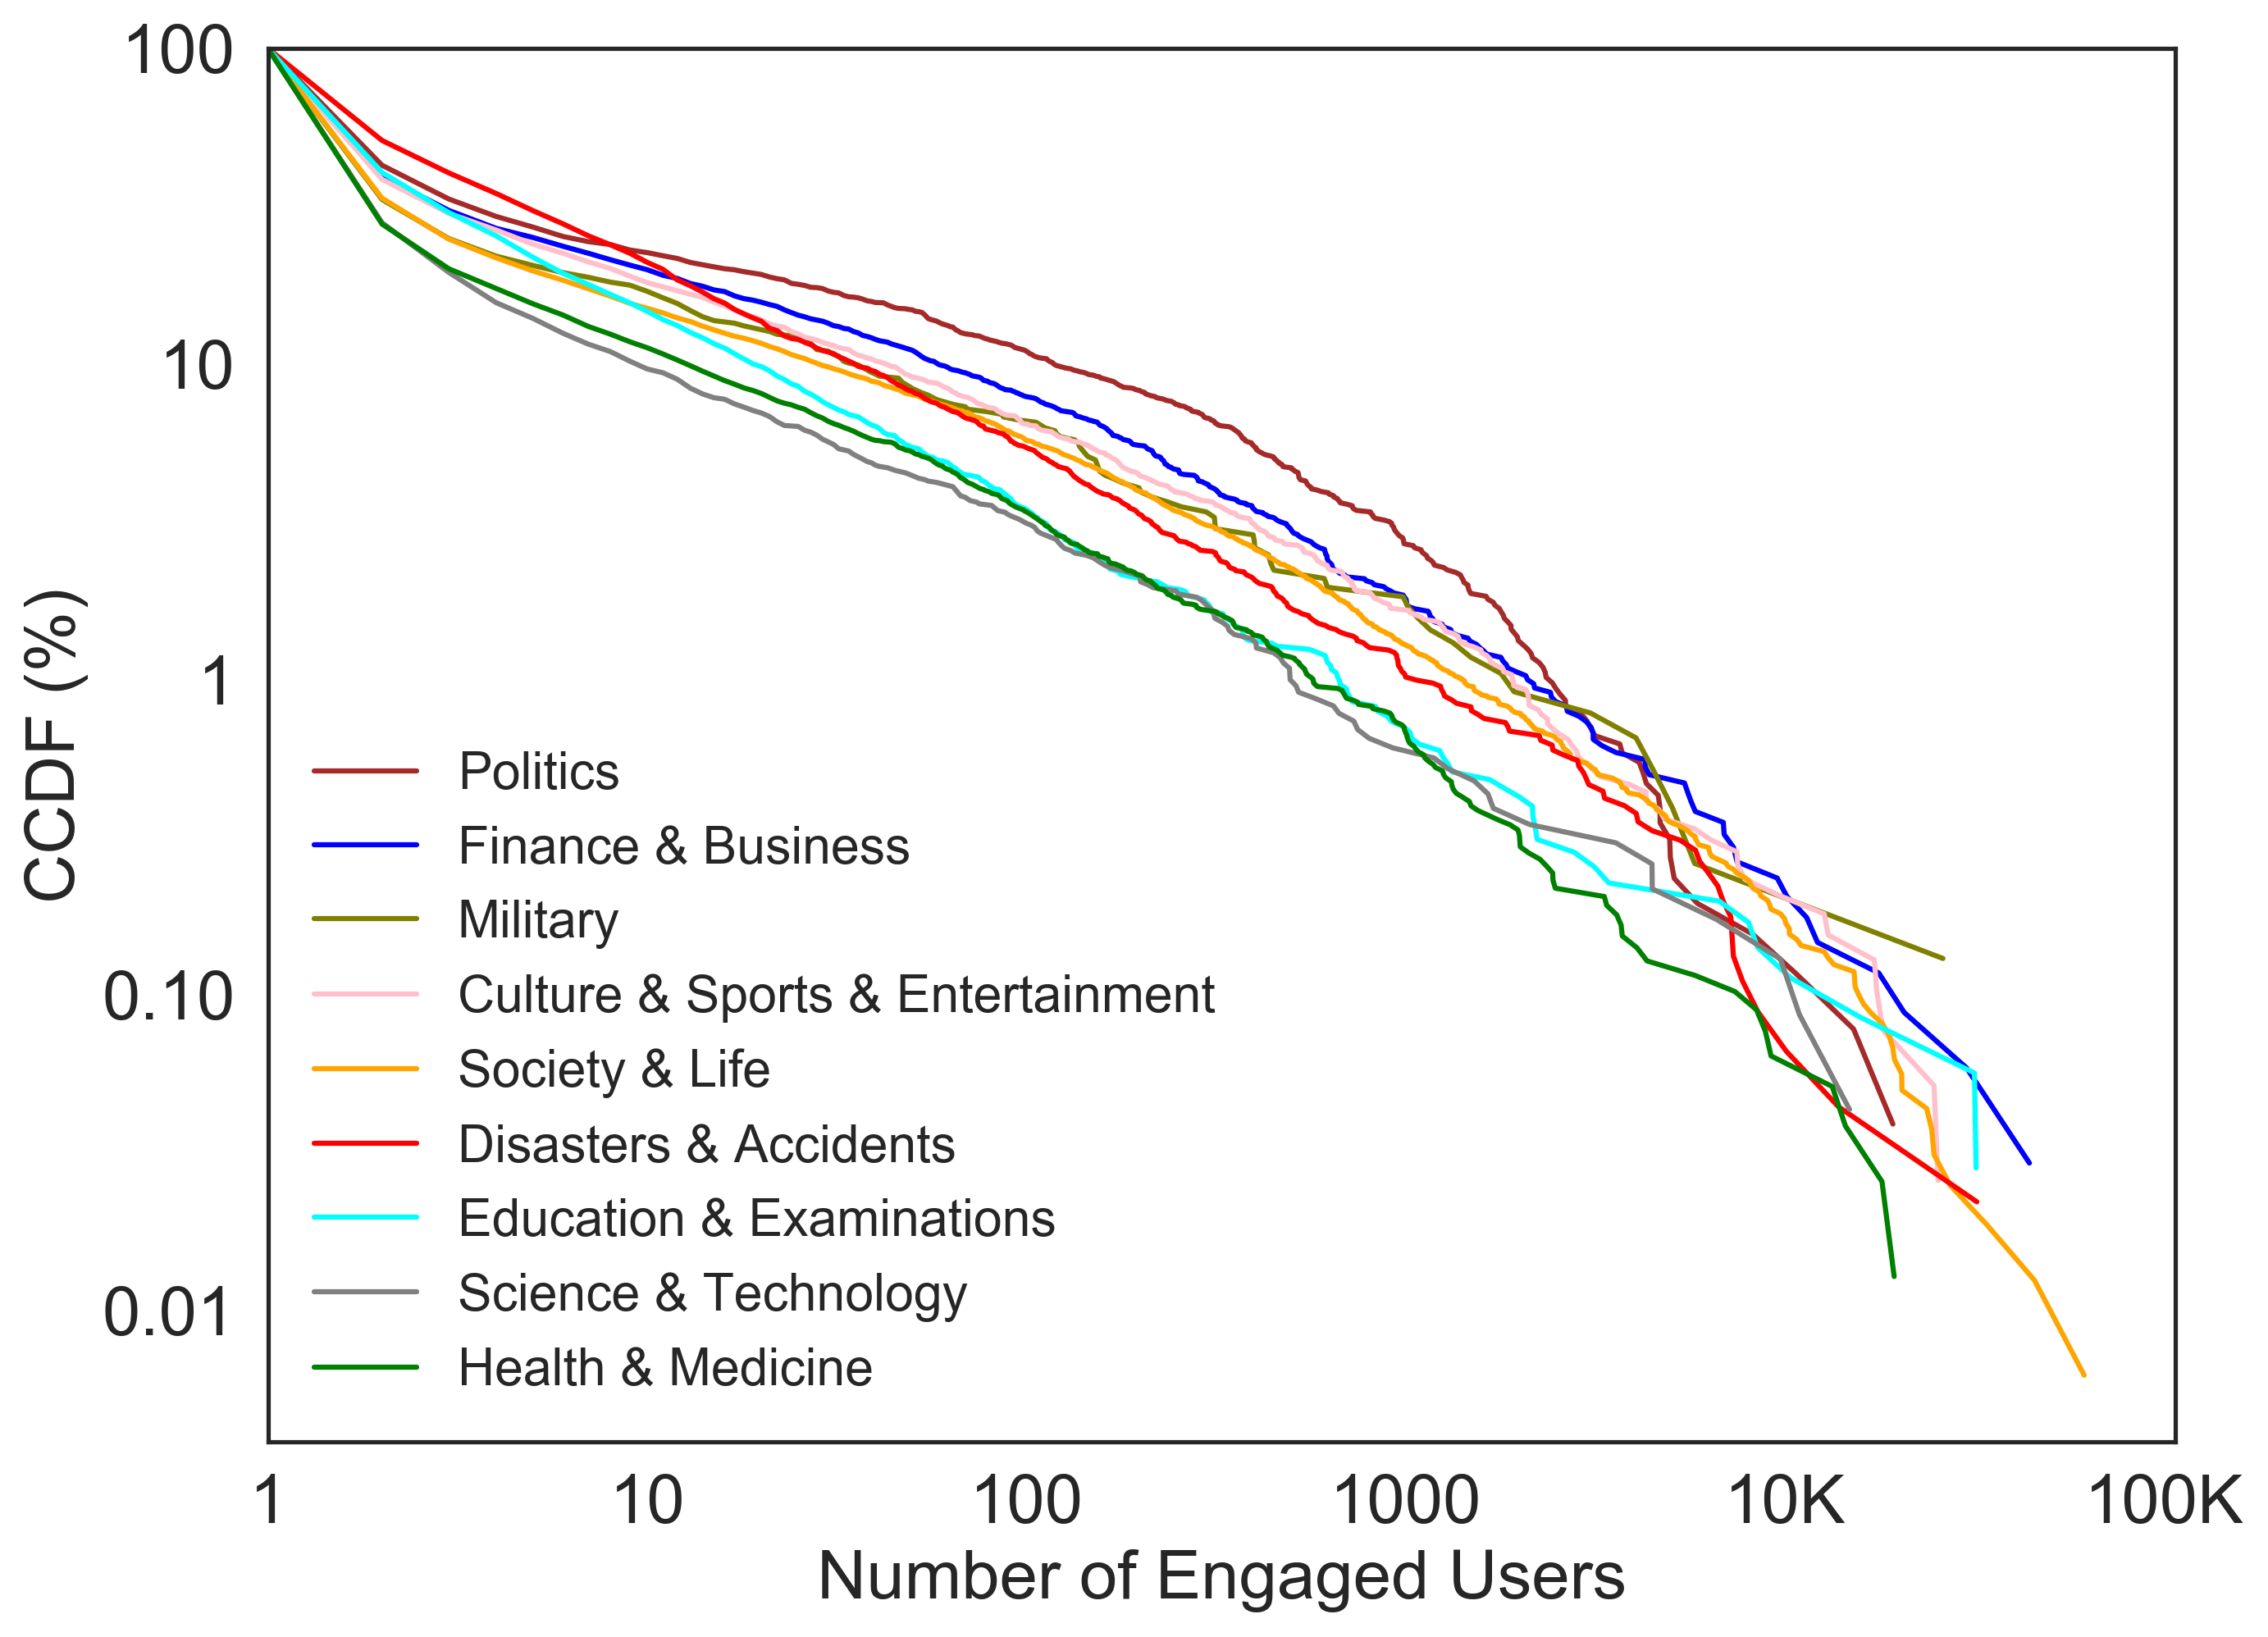

<Figure size 3000x2250 with 0 Axes>

In [80]:
plot_CCDF(neu, 'Number of Engaged Users', './figs/fig_2D.pdf')

## Rankings for Diffusion Capacity (Table 3)

In [81]:
# Normailze Area (NA)
normed_ints = {}
normed_ints['All measures'] = {domain:0 for domain in ordered_domains}
for measure, stat in ints.items():
    max_int = np.max(list(stat.values()))
    normed_stat = {k : (v / max_int) for k, v in stat.items()}
    normed_ints[measure] = normed_stat
    normed_ints['All measures'] = {k : normed_ints['All measures'][k] + (v / max_int) 
                                   for k, v in stat.items()}

rank_ints = {}
for measure, data in normed_ints.items():
    values = list(data.values())
    values.sort(reverse=True)
    ranks = {k : (int(values.index(v)) + 1) for k, v in data.items()}
    rank_ints[measure] = ranks

diff_capacity_table = {domain:{} for domain in ordered_domains}
measures = ['Size', 'Maximum Depth', 'Maximum Breadth', 
            'Number of Engaged Users', 'All measures']
for domain in ordered_domains:
    obj = {}
    for mea in measures:
        obj[mea + '_NA'] = normed_ints[mea][domain]
        obj[mea + '_R'] = rank_ints[mea][domain]
    diff_capacity_table[domain] = obj
diff_capacity_table = pd.DataFrame(diff_capacity_table).T
diff_capacity_table

All measures_NA  All measures_R  \
Politics                                 3.796750             1.0   
Finance & Business                       3.745187             2.0   
Military                                 3.568694             3.0   
Culture & Sports & Entertainment         3.153071             4.0   
Society & Life                           2.861772             5.0   
Disasters & Accidents                    2.480309             6.0   
Education & Examinations                 2.157126             7.0   
Science & Technology                     1.581754             8.0   
Health & Medicine                        1.469295             9.0   

                                  Maximum Breadth_NA  Maximum Breadth_R  \
Politics                                    0.801080                3.0   
Finance & Business                          0.996719                2.0   
Military                                    1.000000                1.0   
Culture & Sports & Entertainment            0.753825                4.0   
Society & Life                              0.696612                5.0   
Disasters & Accidents                       0.524647                6.0   
Education & Examinations                    0.481454                7.0   
Science & Technology                        0.404687                8.0   
Health & Medicine                           0.332124                9.0   

                                  Maximum Depth_NA  Maximum Depth_R  \
Politics                                  1.000000              1.0   
Finance & Business                        0.763596              4.0   
Military                                  0.713696              5.0   
Culture & Sports & Entertainment          0.773847              3.0   
Society & Life                            0.687703              7.0   
Disasters & Accidents                     0.823664              2.0   
Education & Examinations                  0.694241              6.0   
Science & Technology                      0.467398              9.0   
Health & Medicine                         0.519398              8.0   

                                  Number of Engaged Users_NA  \
Politics                                            0.995670   
Finance & Business                                  1.000000   
Military                                            0.927839   
Culture & Sports & Entertainment                    0.814913   
Society & Life                                      0.740810   
Disasters & Accidents                               0.569251   
Education & Examinations                            0.493852   
Science & Technology                                0.353375   
Health & Medicine                                   0.310878   

                                  Number of Engaged Users_R   Size_NA  Size_R  
Politics                                                2.0  1.000000     1.0  
Finance & Business                                      1.0  0.984872     2.0  
Military                                                3.0  0.927159     3.0  
Culture & Sports & Entertainment                        4.0  0.810486     4.0  
Society & Life                                          5.0  0.736647     5.0  
Disasters & Accidents                                   6.0  0.562747     6.0  
Education & Examinations                                7.0  0.487579     7.0  
Science & Technology                                    8.0  0.356294     8.0  
Health & Medicine                                       9.0  0.306894     9.0

# Role of Engaged Users (Section 5)

## User Characteristics (Section 5.1)

### Gender (Fig. 3)

In [82]:
gender_dist = {domain:{'male': 0, 'female': 0} for domain in ordered_domains}
gender_dist['All domains'] = {'male': 0, 'female': 0}
for og in og_coll.find({}):
    if og['userType'] != 'Verified Organization':
        gender_dist[og['domain']][og['userGender']] += 1
        gender_dist['All domains'][og['userGender']] += 1
for domain in gender_dist.keys():
    domain_total = sum(gender_dist[domain].values())
    gender_dist[domain]['%male'] = gender_dist[domain]['male'] / domain_total
    gender_dist[domain]['%female'] = 1 - gender_dist[domain]['%male']
gender_dist['Weibo Registers'] = {'male':'-', 'female':'-', '%male':0.57, '%female':0.43}
gender_dist = pd.DataFrame(gender_dist).T
gender_dist

%female     %male female   male
Politics                          0.188201  0.811799    453   1954
Finance & Business                0.300697  0.699303    820   1907
Military                          0.232722  0.767278    165    544
Culture & Sports & Entertainment  0.389974  0.610026   1338   2093
Society & Life                    0.488615  0.511385   7124   7456
Disasters & Accidents             0.446358  0.553642   1918   2379
Education & Examinations          0.462397  0.537603   1408   1637
Science & Technology                0.4233    0.5767    803   1094
Health & Medicine                 0.556262  0.443738   3851   3072
All domains                       0.446821  0.553179  17880  22136
Weibo Registers                       0.43      0.57      -      -

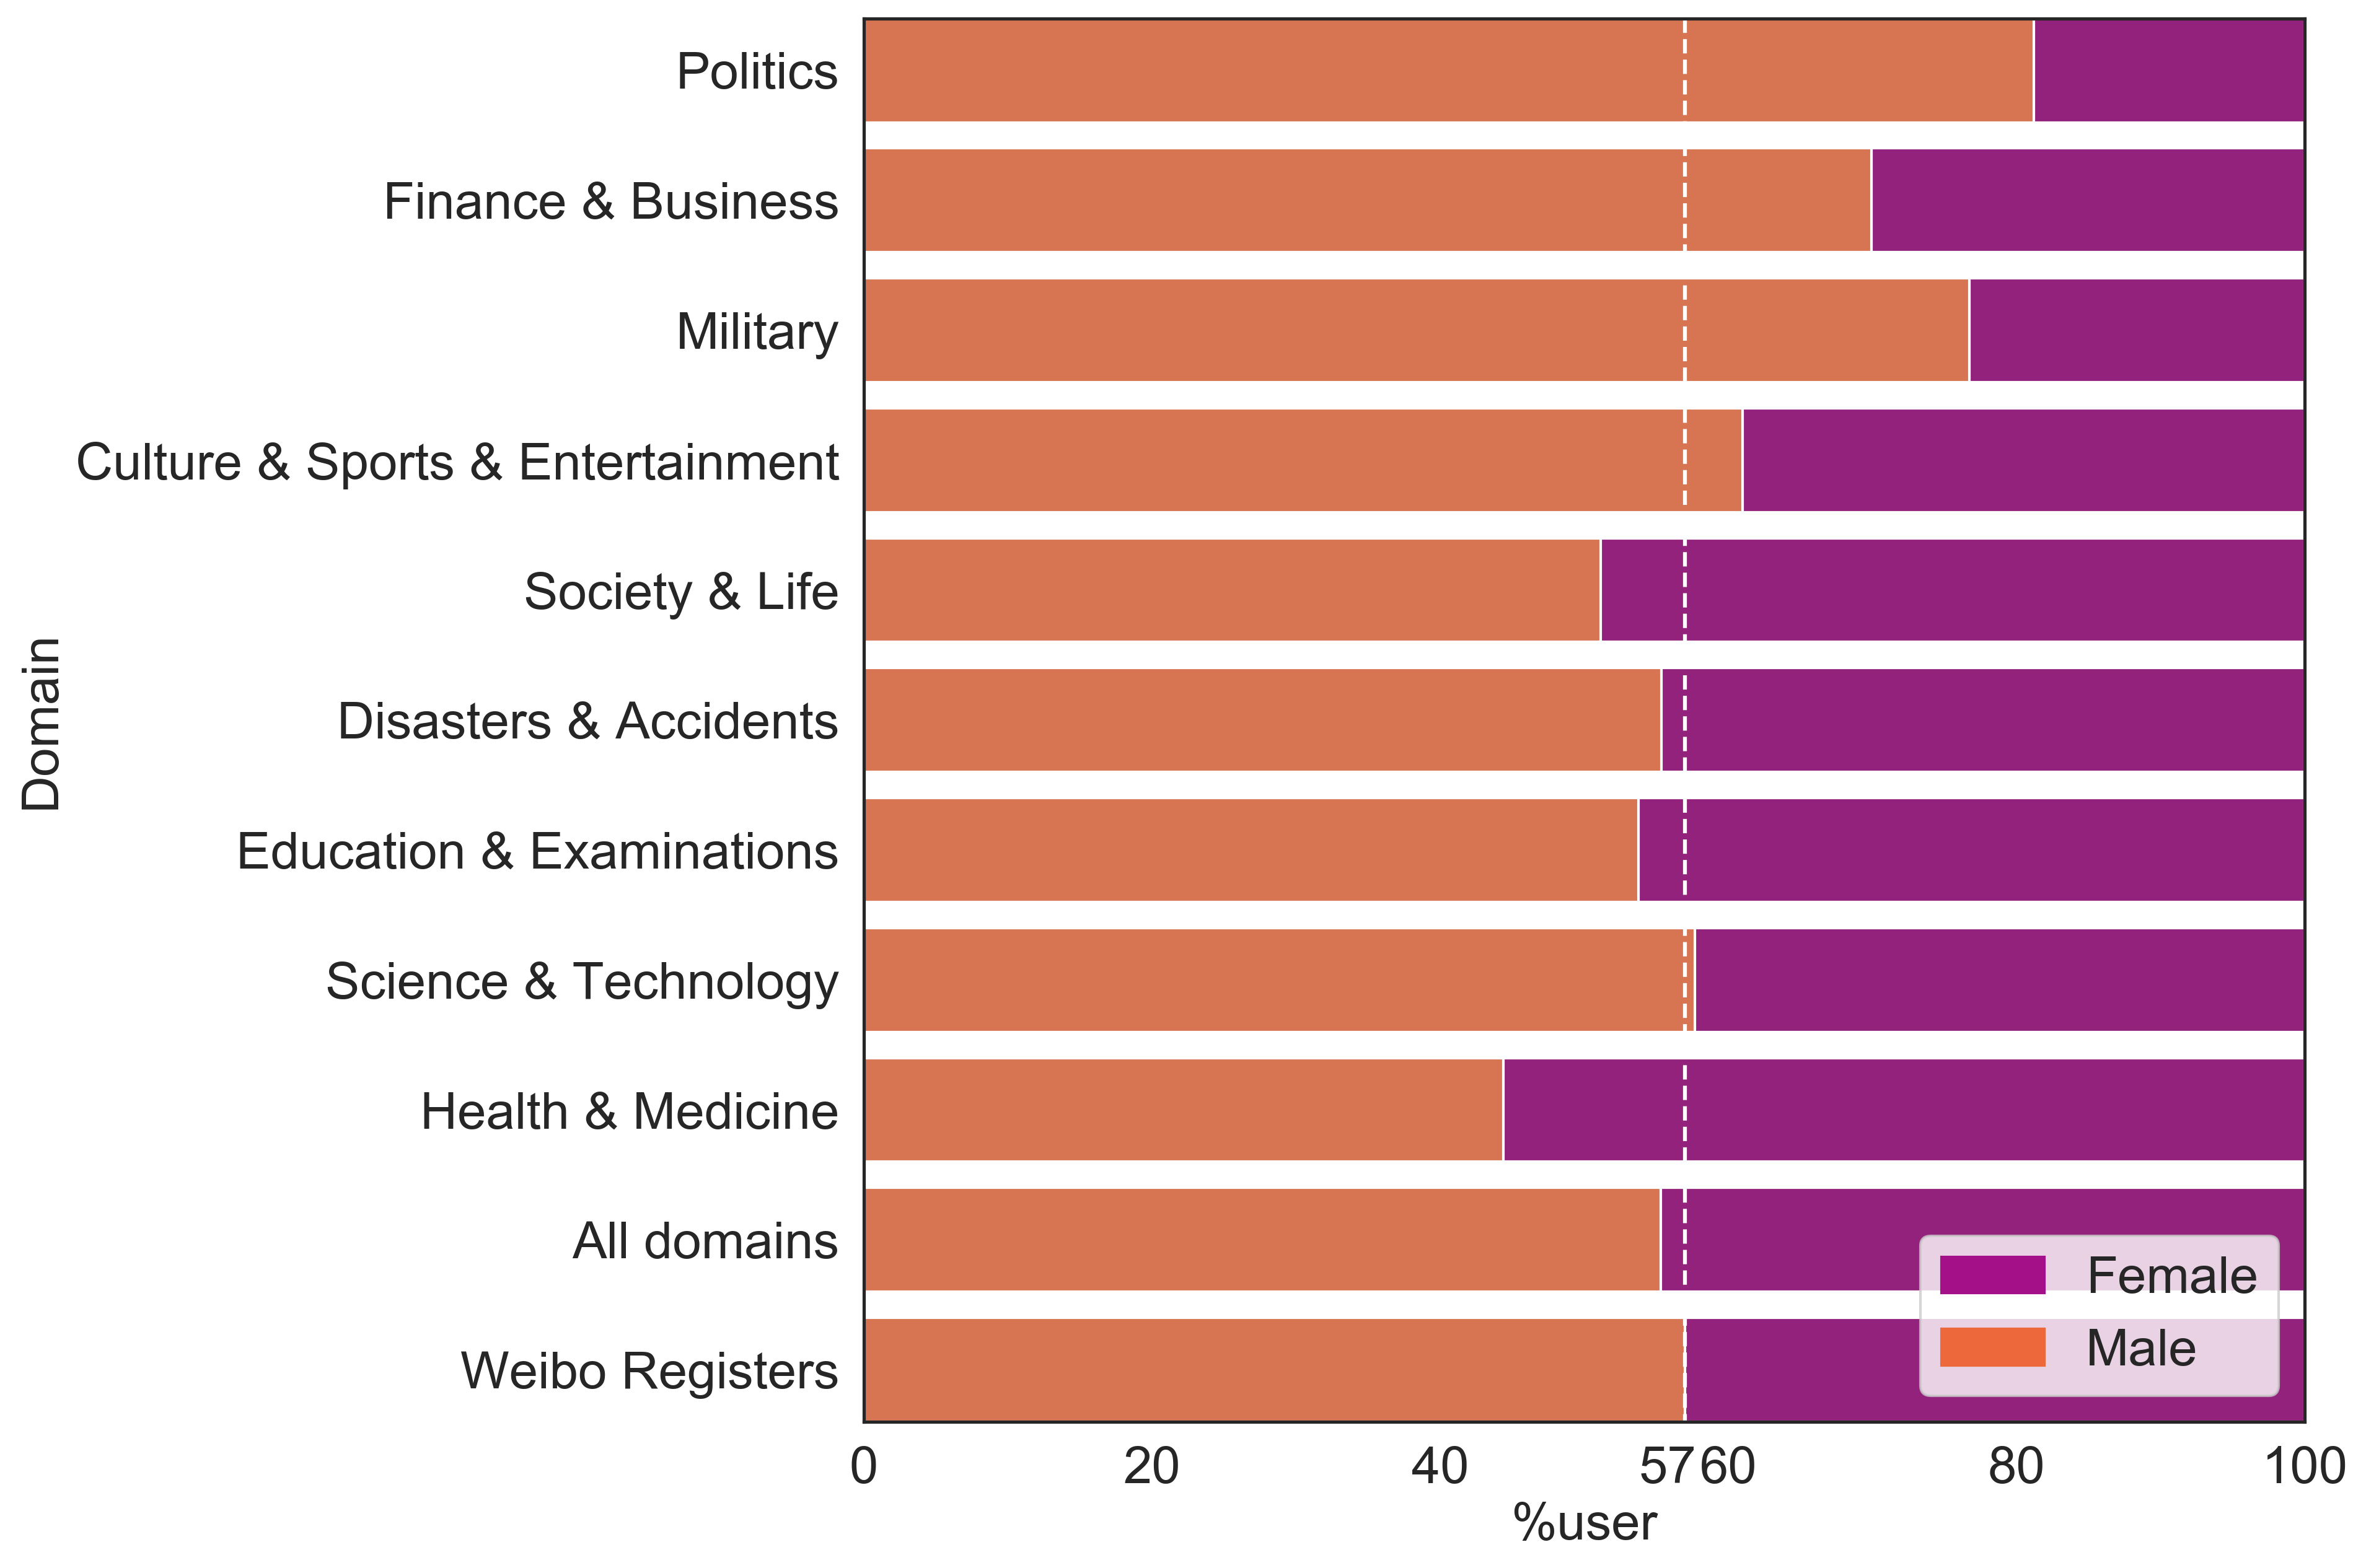

In [85]:
# plot
sns.set_context({"figure.figsize": (10,10)})
 
#Plot 1 - background - "total" (top) series
top_plot = sns.barplot(y = gender_dist.index, x = np.ones(11) * 100.0, 
                       orient="h", color='#A41088')

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(y = gender_dist.index, x = gender_dist['%male']* 100.0, 
                          orient="h", color='#ED693C')

bottom_plot.set_xlabel("%user", fontsize = 20)
bottom_plot.set_ylabel("Domain", fontsize = 20)
bottom_plot.set_yticklabels(gender_dist.index, rotation=0, fontsize=20)
bottom_plot.set_xticklabels([0, 20,40,60,80,100], fontsize=20)
bottom_plot.set(xlim=(0,100), ylim=(10.4,-0.4))

w_patch = mpatches.Patch(color='#ED693C', label='Male')
t_patch = mpatches.Patch(color='#A41088', label='Female')
plt.legend(handles=[t_patch, w_patch], loc=4, ncol = 1, prop={'size':20})

bottom_plot.vlines(57, -0.4, 10.4, linestyles='--', colors='#ffffff', label='wo')
bottom_plot.text(53.8, 10.87, '57', fontsize=20)

plt.savefig('./figs/fig_3.pdf', bbox_inches='tight', format='pdf')

### Age (Table 4 and Fig. 4)

In [86]:
# Table 4
age_dist = {domain:[] for domain in ordered_domains}
age_dist['All domains'] = []
for og in og_coll.find({'userBirthYear':{'$ne':-1}}):
    # age is calculated when a user published the collected post
    age = og['pubYear'] - og['userBirthYear']
    if age > 6 and age < 100:
        age_dist[og['domain']].append(age)
        age_dist['All domains'].append(age)

In [87]:
age_stat = {domain:{} for domain in ordered_domains}
age_stat['All domains'] = {}
for domain in age_stat.keys():
    age_stat[domain]['Average'] = np.average(age_dist[domain])
    age_stat[domain]['Upper Quartile'] = np.quantile(age_dist[domain], .75)
    age_stat[domain]['N(<30)'] = np.sum(list(map(lambda x : x < 30, age_dist[domain])))
    age_stat[domain]['N(30~65)'] = np.sum(list(map(lambda x : x >= 30 and x <= 65, age_dist[domain])))
    age_stat[domain]['N(>65)'] = np.sum(list(map(lambda x : x >= 65, age_dist[domain])))
    total = len(age_dist[domain])
    age_stat[domain]['%(<30)'] = age_stat[domain]['N(<30)'] / total
    age_stat[domain]['%(30~65)'] = age_stat[domain]['N(30~65)'] / total
    age_stat[domain]['%(>65)'] = age_stat[domain]['N(>65)'] / total   
age_stat = pd.DataFrame(age_stat).T
age_stat = age_stat[['Average', 'Upper Quartile', 'N(<30)', '%(<30)', 'N(30~65)', '%(30~65)',
             'N(>65)', '%(>65)']]
age_stat

Average  Upper Quartile   N(<30)  \
Politics                          34.562660            42.0    337.0   
Finance & Business                31.929150            38.0    513.0   
Military                          34.171315            42.0    113.0   
Culture & Sports & Entertainment  30.430454            36.0    810.0   
Society & Life                    27.977716            31.0   4767.0   
Disasters & Accidents             27.139353            31.0   1362.0   
Education & Examinations          27.654559            32.0    944.0   
Science & Technology              30.290363            37.0    498.0   
Health & Medicine                 29.478207            33.0   2049.0   
All domains                       29.038457            33.0  11393.0   

                                    %(<30)  N(30~65)  %(30~65)  N(>65)  \
Politics                          0.430946     425.0  0.543478    21.0   
Finance & Business                0.519231     457.0  0.462551    19.0   
Military                          0.450199     129.0  0.513944    10.0   
Culture & Sports & Entertainment  0.592972     530.0  0.387994    29.0   
Society & Life                    0.694291    2054.0  0.299155    53.0   
Disasters & Accidents             0.710856     540.0  0.281837    16.0   
Education & Examinations          0.699778     390.0  0.289103    15.0   
Science & Technology              0.623279     291.0  0.364205    11.0   
Health & Medicine                 0.633385    1142.0  0.353014    46.0   
All domains                       0.649100    5958.0  0.339448   220.0   

                                    %(>65)  
Politics                          0.026854  
Finance & Business                0.019231  
Military                          0.039841  
Culture & Sports & Entertainment  0.021230  
Society & Life                    0.007719  
Disasters & Accidents             0.008351  
Education & Examinations          0.011119  
Science & Technology              0.013767  
Health & Medicine                 0.014219  
All domains                       0.012534

In [88]:
def kdeplot(data, data2=None, shade=False, vertical=False, kernel="gau",
            bw="scott", gridsize=100, cut=3, clip=None, legend=True,
            cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None,
            cbar_kws=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    if isinstance(data, list):
        data = np.asarray(data)

    data = data.astype(np.float64)
    if data2 is not None:
        if isinstance(data2, list):
            data2 = np.asarray(data2)
        data2 = data2.astype(np.float64)

    ax = _univariate_kdeplot(data, shade, vertical, kernel, bw, gridsize, cut, clip, legend, ax,
                             cumulative=cumulative, **kwargs)

    return ax

def _univariate_kdeplot(data, shade, vertical, kernel, bw, gridsize, cut,
                        clip, legend, ax, cumulative=False, **kwargs):
    """Plot a univariate kernel density estimate on one of the axes."""
    
    print(data.shape)
    # Sort out the clipping
    if clip is None:
        clip = (-np.inf, np.inf)

    # Calculate the KDE

    if np.nan_to_num(data.var()) == 0:
        # Don't try to compute KDE on singular data
        msg = "Data must have variance to compute a kernel density estimate."
        warnings.warn(msg, UserWarning)
        x, y = np.array([]), np.array([])

    elif _has_statsmodels:
        # Prefer using statsmodels for kernel flexibility
        x, y = _statsmodels_univariate_kde(data, kernel, bw,
                                           gridsize, cut, clip,
                                           cumulative=cumulative)
    else:
        # Fall back to scipy if missing statsmodels
        if kernel != "gau":
            kernel = "gau"
            msg = "Kernel other than `gau` requires statsmodels."
            warnings.warn(msg, UserWarning)
        if cumulative:
            raise ImportError("Cumulative distributions are currently "
                              "only implemented in statsmodels. "
                              "Please install statsmodels.")
        x, y = _scipy_univariate_kde(data, bw, gridsize, cut, clip)

    # Make sure the density is nonnegative
    y = np.amax(np.c_[np.zeros_like(y), y], axis=1)

    # Flip the data if the plot should be on the y axis
    if vertical:
        x, y = y, x

    # Check if a label was specified in the call
    label = kwargs.pop("label", None)

    # Otherwise check if the data object has a name
    if label is None and hasattr(data, "name"):
        label = data.name

    # Decide if we're going to add a legend
    legend = label is not None and legend
    label = "_nolegend_" if label is None else label

    # Use the active color cycle to find the plot color
    facecolor = kwargs.pop("facecolor", None)
    line, = ax.plot(x, y, **kwargs)
    color = line.get_color()
    line.remove()
    kwargs.pop("color", None)
    facecolor = color if facecolor is None else facecolor

    # Draw the KDE plot and, optionally, shade
    shade_kws = dict(alpha=1, cmap='plasma')
    if shade:
        colors= plt.get_cmap('plasma_r')(norm(x))
        for i in range(x.shape[0]-1):
            ax.fill_between(x[i:], y[i:], color = colors[i])

    # Set the density axis minimum to 0
    if vertical:
        ax.set_xlim(0, auto=None)
    else:
        ax.set_ylim(0, auto=None)

    ax.set_xlabel(ax.get_xlabel(), fontsize = 20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 20)

    return ax

def _statsmodels_univariate_kde(data, kernel, bw, gridsize, cut, clip,
                                cumulative=False):
    """Compute a univariate kernel density estimate using statsmodels."""
    fft = kernel == "gau"
    kde = smnp.KDEUnivariate(data)
    kde.fit(kernel, bw, fft, gridsize=gridsize, cut=cut, clip=clip)
    if cumulative:
        grid, y = kde.support, kde.cdf
    else:
        grid, y = kde.support, kde.density
    return grid, y

def norm(x):
    _range = np.max(x) - np.min(x)
    return (x - np.min(x)) / _range

(782,)
(251,)


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(988,)
(1366,)
(799,)
(3235,)
(6866,)
(1349,)
(1916,)
(17552,)


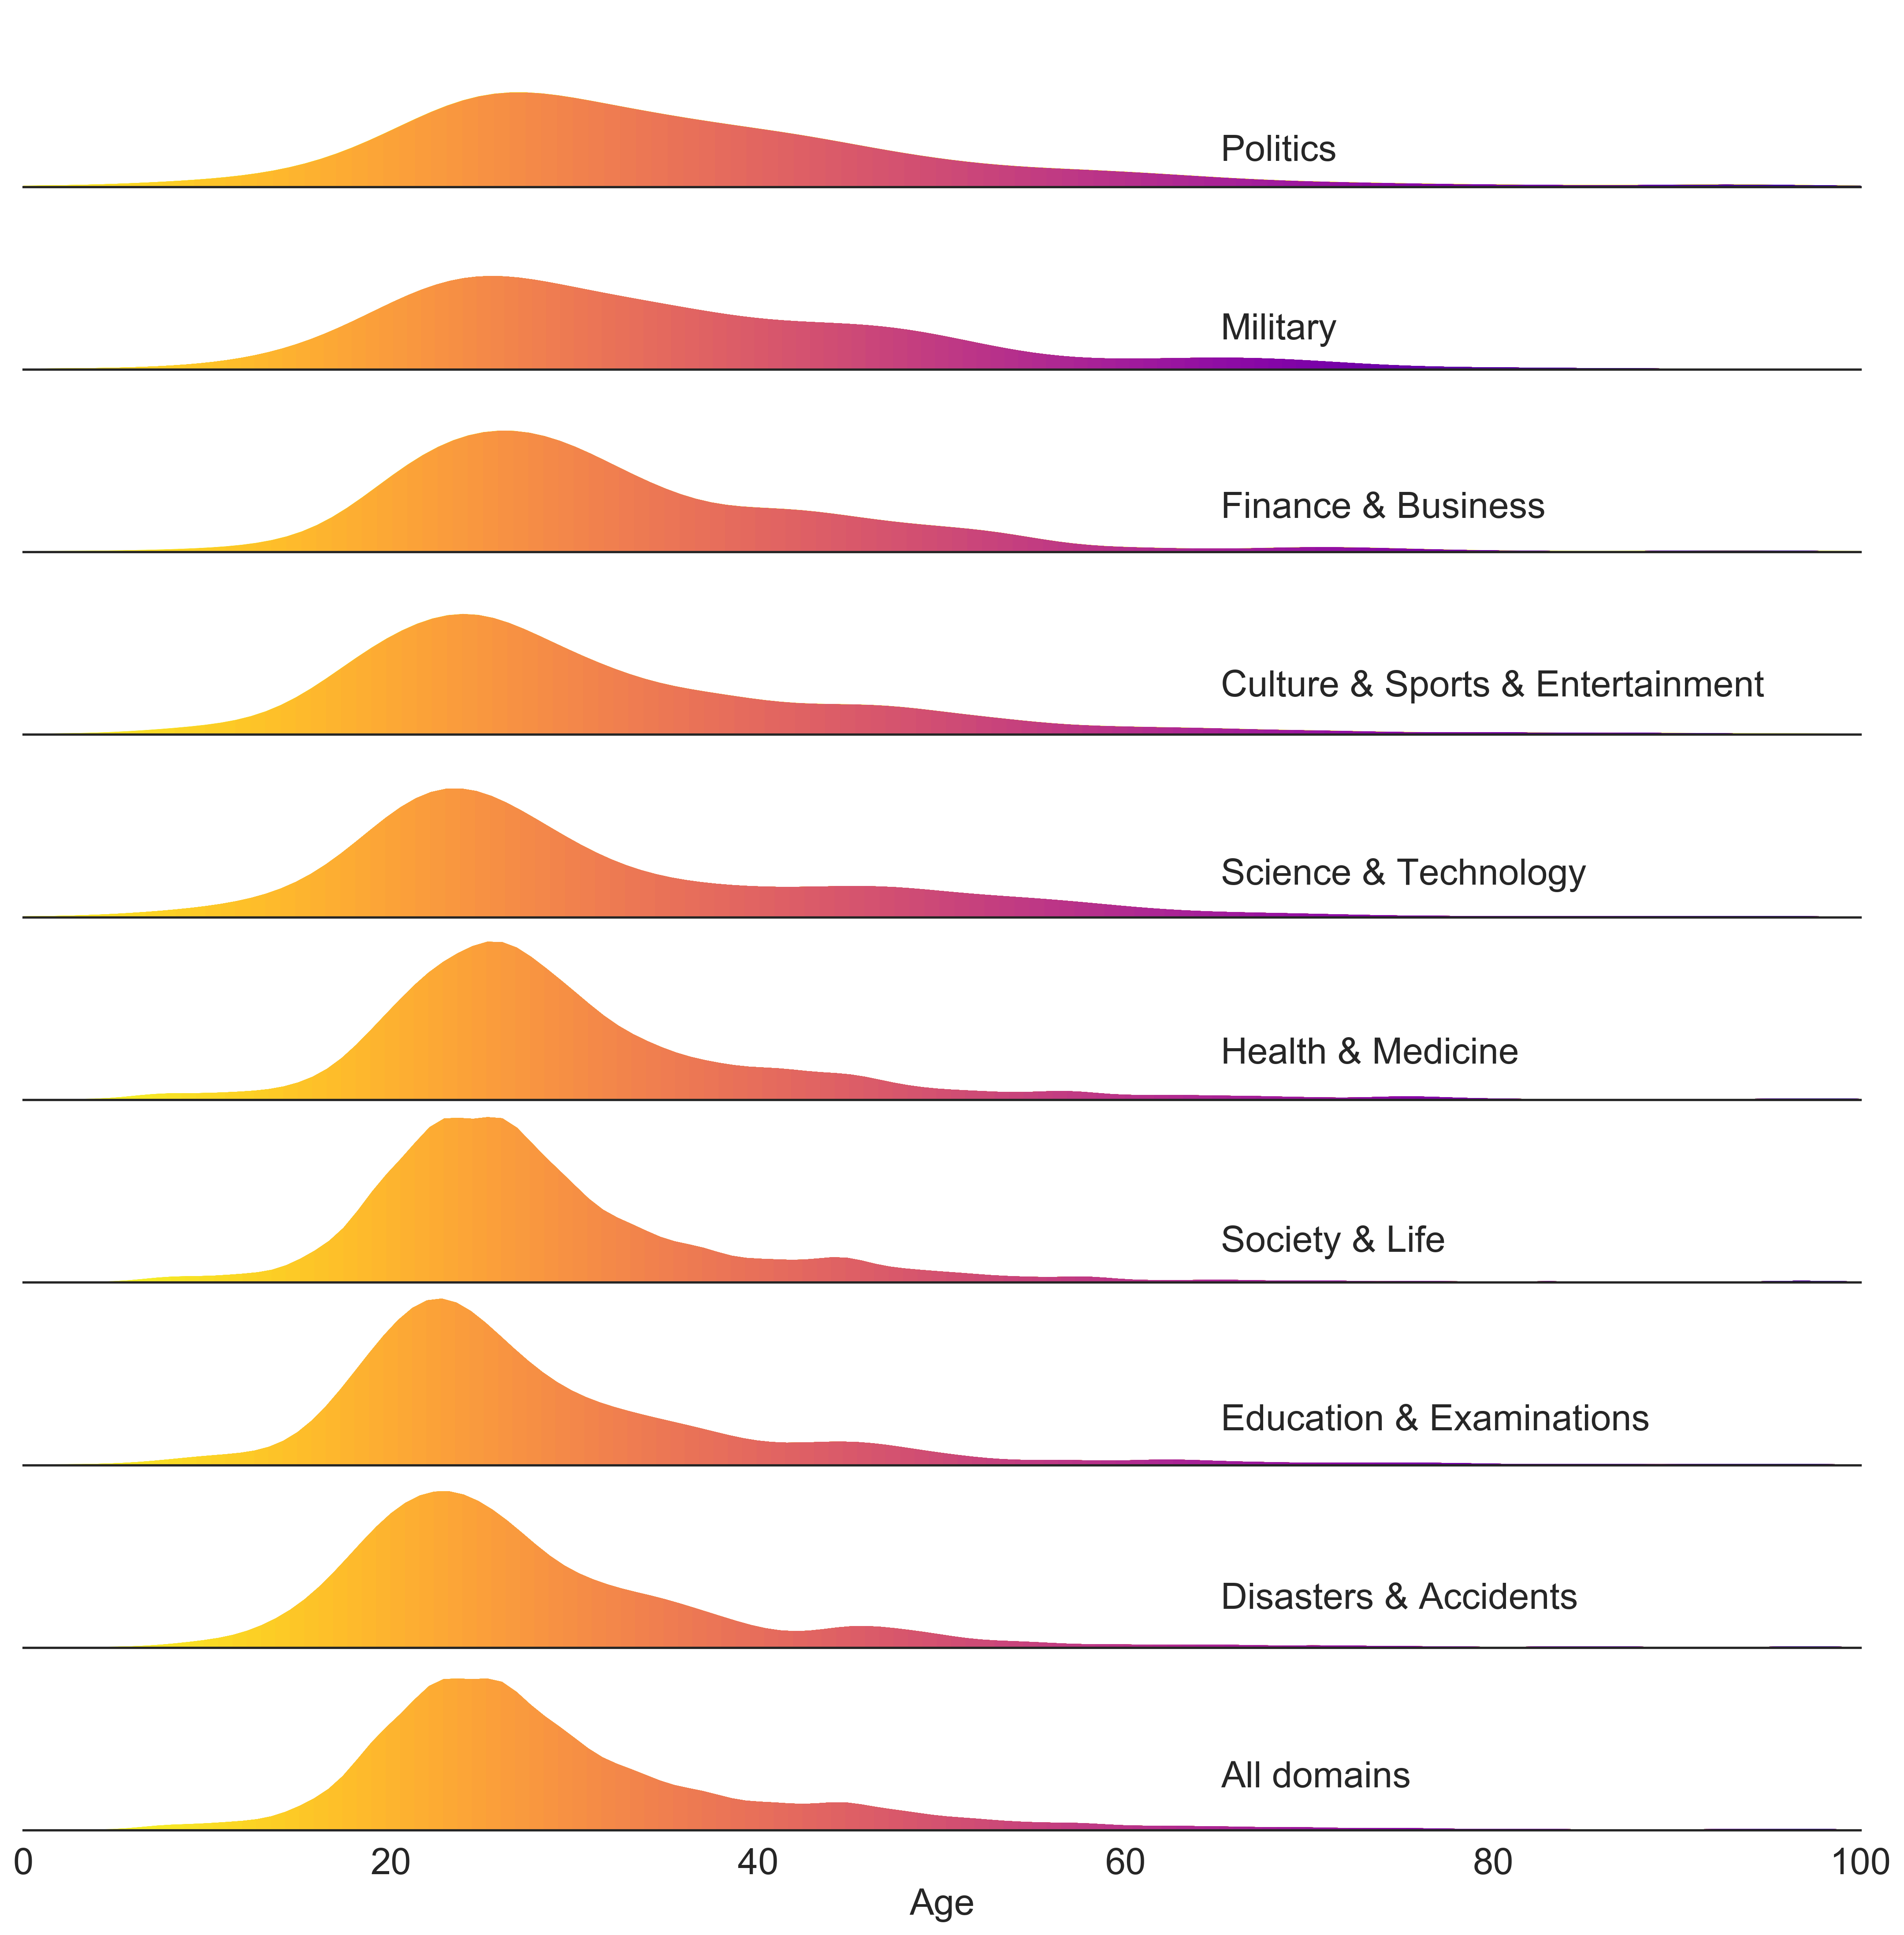

In [89]:
# Figure 4
age_dist_list = []
for domain, ages in age_dist.items():
    for age in ages:
        age_dist_list.append({'Domain':domain, 'Age':age})
age_dist_list = pd.DataFrame(age_dist_list)
sns.set_context({"figure.figsize": (10, 10)})

domain_order = ['Politics', 'Military', 'Finance & Business', 'Culture & Sports & Entertainment', 
               'Science & Technology', 'Health & Medicine', 'Society & Life', 
               'Education & Examinations','Disasters & Accidents', 'All domains']

pal = sns.cubehelix_palette(10, light=.7, reverse = True)

age_plot = sns.FacetGrid(age_dist_list, row="Domain", hue="Domain", 
                         aspect=10, height=1.5, xlim=(0,100),
                         sharex=True, sharey=True, 
                         row_order = domain_order)
age_plot = age_plot.map(kdeplot, "Age", clip_on=False, shade=True, alpha=1)

age_plot.fig.subplots_adjust(hspace=.05)

age_plot.fig.text(0.65, 0.9, 'Politics', fontsize=20)
age_plot.fig.text(0.65, 0.81, 'Military', fontsize=20)
age_plot.fig.text(0.65, 0.72, 'Finance & Business', fontsize=20)
age_plot.fig.text(0.65, 0.63, 'Culture & Sports & Entertainment', fontsize=20)
age_plot.fig.text(0.65, 0.535, 'Science & Technology', fontsize=20)
age_plot.fig.text(0.65, 0.445, 'Health & Medicine', fontsize=20)
age_plot.fig.text(0.65, 0.35, 'Society & Life', fontsize=20)
age_plot.fig.text(0.65, 0.26, 'Education & Examinations', fontsize=20)
age_plot.fig.text(0.65, 0.17, 'Disasters & Accidents', fontsize=20)
age_plot.fig.text(0.65, 0.08, 'All domains', fontsize=20)

age_plot.set_titles("")
age_plot.set(yticks=[])
age_plot.despine(left=True)

plt.savefig('./figs/fig_4.pdf', bbox_inches='tight', format='pdf')

### Account (Table 5~7)

#### Table 5

In [91]:
account_dist = {domain:{} for domain in ordered_domains}
account_dist['All domains'] = {}
type_order = ['Unverified User', 'Verified Individual',
             'Verified Organization']
total_st_cnt = [0, 0, 0]
total_rp_cnt = [0, 0, 0]

for domain in ordered_domains:
    st_cnt = [0, 0, 0]
    rp_cnt = [0, 0, 0]
    
    for og in og_coll.find({
        'domain':domain,
        'userType':{'$in':['Ordinary User','Active Ordinary User']}
    }):
        st_cnt[0] += 1
        rp_cnt[0] += og['size']
    for og in og_coll.find({
        'domain':domain,
        'userType':'Verified Individual'
    }):
        st_cnt[1] += 1
        rp_cnt[1] += og['size']
    for og in og_coll.find({
        'domain':domain,
        'userType':'Verified Organization'
    }):
        st_cnt[2] += 1
        rp_cnt[2] += og['size']
    rp_cnt = [rp_cnt[i] - st_cnt[i] for i in range(3)]
    total_st_cnt = [total_st_cnt[i] + st_cnt[i] for i in range(3)]
    total_rp_cnt = [total_rp_cnt[i] + rp_cnt[i] for i in range(3)]
    st_p = [st_cnt[i] / sum(st_cnt)  for i in range(3)]
    rp_p = [rp_cnt[i] / sum(rp_cnt)  for i in range(3)]
    
    for i in range(3):
        account_dist[domain][type_order[i] + '_%rp'] = rp_p[i]
        account_dist[domain][type_order[i] + '_%st'] = st_p[i]
        
# Calculate the total
total_st_p = [total_st_cnt[i] / sum(total_st_cnt)  for i in range(3)]
total_rp_p = [total_rp_cnt[i] / sum(total_rp_cnt)  for i in range(3)]
for i in range(3):
    account_dist['All domains'][type_order[i] + '_%rp'] = total_rp_p[i]
    account_dist['All domains'][type_order[i] + '_%st'] = total_st_p[i]
        
account_dist = pd.DataFrame(account_dist).T
account_dist = account_dist[
    ['Unverified User_%st', 'Unverified User_%rp',
     'Verified Individual_%st', 'Verified Individual_%rp',
     'Verified Organization_%st', 'Verified Organization_%rp']
]
account_dist

Unverified User_%st  Unverified User_%rp  \
Politics                                     0.757031             0.587951   
Finance & Business                           0.579365             0.319015   
Military                                     0.758170             0.658902   
Culture & Sports & Entertainment             0.691930             0.375262   
Society & Life                               0.765981             0.428019   
Disasters & Accidents                        0.751052             0.395089   
Education & Examinations                     0.713071             0.428308   
Science & Technology                         0.662467             0.455241   
Health & Medicine                            0.749230             0.354666   
All domains                                  0.730817             0.420981   

                                  Verified Individual_%st  \
Politics                                         0.183203   
Finance & Business                               0.222222   
Military                                         0.168627   
Culture & Sports & Entertainment                 0.195551   
Society & Life                                   0.145098   
Disasters & Accidents                            0.200664   
Education & Examinations                         0.150269   
Science & Technology                             0.161599   
Health & Medicine                                0.139702   
All domains                                      0.163835   

                                  Verified Individual_%rp  \
Politics                                         0.353931   
Finance & Business                               0.460723   
Military                                         0.311638   
Culture & Sports & Entertainment                 0.567552   
Society & Life                                   0.490599   
Disasters & Accidents                            0.347816   
Education & Examinations                         0.493855   
Science & Technology                             0.381372   
Health & Medicine                                0.479880   
All domains                                      0.463525   

                                  Verified Organization_%st  \
Politics                                           0.059766   
Finance & Business                                 0.198413   
Military                                           0.073203   
Culture & Sports & Entertainment                   0.112519   
Society & Life                                     0.088921   
Disasters & Accidents                              0.048283   
Education & Examinations                           0.136660   
Science & Technology                               0.175934   
Health & Medicine                                  0.111068   
All domains                                        0.105348   

                                  Verified Organization_%rp  
Politics                                           0.058118  
Finance & Business                                 0.220263  
Military                                           0.029461  
Culture & Sports & Entertainment                   0.057186  
Society & Life                                     0.081382  
Disasters & Accidents                              0.257095  
Education & Examinations                           0.077837  
Science & Technology                               0.163386  
Health & Medicine                                  0.165454  
All domains                                        0.115493

#### Table 6

In [90]:
org_repost_beliefs = {}
global_aggs = {k:0 for k in rp_coll.distinct('label')}

beliefs_order = ['believe', 'debunk', 'DNB', 'doubt', 'unknown']
orgs_order = ['Police', 'Government', 'Media', 'Company',
              'School', 'Social Org.', 'Total']

match = {'userType':'Verified Organization'}
group = {'_id':'$userDomain', 'label':{'$sum':1}}

for udom in rp_coll.distinct('userDomain', match):
    aggs = {}
    for agg in rp_coll.aggregate([{'$match':{'userType':'Verified Organization',
                                             'userDomain':udom}},
                                  {'$group':{'_id':'$label', 
                                             'label':{'$sum':1}}}]):
        aggs[agg['_id']] = agg['label']
        global_aggs[agg['_id']] += agg['label']
    local_total = sum(aggs.values())
    normed_aggs = {k:v/local_total for k,v in aggs.items()}
    org_repost_beliefs[udom] = normed_aggs
global_total = sum(global_aggs.values())
org_repost_beliefs['Total'] = {k:v/global_total for k,v in global_aggs.items()}

org_repost_beliefs = pd.DataFrame(org_repost_beliefs).T
org_repost_beliefs = org_repost_beliefs[beliefs_order]
org_repost_beliefs = org_repost_beliefs.T
org_repost_beliefs = org_repost_beliefs[orgs_order]
org_repost_beliefs


Police  Government     Media   Company    School  Social Org.  \
believe  0.768755    0.855015  0.708822  0.884231  0.878214     0.803922   
debunk   0.074246    0.031778  0.093003  0.005199  0.014885     0.007353   
DNB      0.143078    0.099305  0.120817  0.048339  0.067659     0.095588   
doubt    0.004640    0.003972  0.046067  0.032009  0.033829     0.036765   
unknown  0.009281    0.009930  0.031291  0.030222  0.005413     0.056373   

            Total  
believe  0.849920  
debunk   0.023260  
DNB      0.069059  
doubt    0.030459  
unknown  0.027302

#### Table 7

In [92]:
org_fooled_dist = {domain:{'Number of the fooling-organization posts':0} 
                   for domain in ordered_domains}
fooling_org_posts_total = 0
column_order = [
    'Number of the fooling-organization posts',
    'Proportion of the fooling-organization posts',
    'Number of all reposted false original posts',
    'Proportion of all reposted false original posts',
    'Difference'
]

repostedIds = set()
for rp in rp_coll.find({'userType' : 'Verified Organization',
                        'label':'believe'}):
    repostedIds.add(rp['forwardedId'])

for rpid in repostedIds:
    domain = og_coll.find_one({'weiboId':rpid})['domain']
    org_fooled_dist[domain]['Number of the fooling-organization posts'] += 1
    fooling_org_posts_total +=1

og_total = og_coll.count_documents({'size':{'$gt':1}})

for domain in ordered_domains:
    org_fooled_dist[domain]['Proportion of the fooling-organization posts']=\
    org_fooled_dist[domain]['Number of the fooling-organization posts'] / fooling_org_posts_total
    
    org_fooled_dist[domain]['Number of all reposted false original posts'] = \
    og_coll.count_documents({'domain':domain, 'size':{'$gt':1}})
    
    org_fooled_dist[domain]['Proportion of all reposted false original posts'] = \
    org_fooled_dist[domain]['Number of all reposted false original posts'] / og_total
    
    org_fooled_dist[domain]['Difference'] = \
    org_fooled_dist[domain]['Proportion of the fooling-organization posts'] - \
    org_fooled_dist[domain]['Proportion of all reposted false original posts']
    
org_fooled_dist = pd.DataFrame(org_fooled_dist).T
org_fooled_dist = org_fooled_dist[column_order]
org_fooled_dist


Number of the fooling-organization posts  \
Politics                                                             263.0   
Finance & Business                                                   310.0   
Military                                                              39.0   
Culture & Sports & Entertainment                                     250.0   
Society & Life                                                      1102.0   
Disasters & Accidents                                                278.0   
Education & Examinations                                             258.0   
Science & Technology                                                 115.0   
Health & Medicine                                                    418.0   

                                  Proportion of the fooling-organization posts  \
Politics                                                              0.086713   
Finance & Business                                                    0.102209   
Military                                                              0.012859   
Culture & Sports & Entertainment                                      0.082427   
Society & Life                                                        0.363337   
Disasters & Accidents                                                 0.091658   
Education & Examinations                                              0.085064   
Science & Technology                                                  0.037916   
Health & Medicine                                                     0.137817   

                                  Number of all reposted false original posts  \
Politics                                                               1122.0   
Finance & Business                                                     1381.0   
Military                                                                268.0   
Culture & Sports & Entertainment                                       1531.0   
Society & Life                                                         5623.0   
Disasters & Accidents                                                  2350.0   
Education & Examinations                                               1484.0   
Science & Technology                                                    664.0   
Health & Medicine                                                      2265.0   

                                  Proportion of all reposted false original posts  \
Politics                                                                 0.067234   
Finance & Business                                                       0.082754   
Military                                                                 0.016059   
Culture & Sports & Entertainment                                         0.091743   
Society & Life                                                           0.336949   
Disasters & Accidents                                                    0.140820   
Education & Examinations                                                 0.088926   
Science & Technology                                                     0.039789   
Health & Medicine                                                        0.135726   

                                  Difference  
Politics                            0.019479  
Finance & Business                  0.019455  
Military                           -0.003201  
Culture & Sports & Entertainment   -0.009316  
Society & Life                      0.026388  
Disasters & Accidents              -0.049161  
Education & Examinations           -0.003862  
Science & Technology               -0.001873  
Health & Medicine                   0.002091

## User Emotions (Section 5.2, Fig. 5)

In [93]:
emotions = ['disgust', 'like', 'anger', 'sadness', 'surprise', 'joy', 'fear']
emotions_cap = ['Disgust', 'Like', 'Anger', 'Sadness', 'Surprise', 'Joy', 'Fear']
diff_capacity = [1,2,3,4,5,6,7,8,9]

### Whole Emotional Intensity (Section 5.2)

In [94]:
# Original Posts
orig_post_emo_int = {t:0 for t in ordered_domains}

for og in og_coll.find({}):
    orig_post_emo_int[og['domain']] += og['emo_weiboContent']['total']

orig_post_emo_int = {t:orig_post_emo_int[t] / og_coll.count_documents({'domain':t})
                     for t in ordered_domains}

sorted_orig_post_emo_int = list(orig_post_emo_int.values())
sorted_orig_post_emo_int.sort(reverse=True)
orig_post_emo_int_rank = [sorted_orig_post_emo_int.index(v)+1 for v in orig_post_emo_int.values()]

print(orig_post_emo_int_rank)
print(spearmanr(diff_capacity, orig_post_emo_int_rank))

[5, 8, 2, 1, 6, 9, 3, 7, 4]
SpearmanrResult(correlation=0.049999999999999996, pvalue=0.8983528043506301)


In [95]:
# Reposts
rp_domain = {domain:0 for domain in ordered_domains}
for t in ordered_domains:
    for og in og_coll.find({'domain':t}):
        rp_domain[t] += (og['size'] - 1)

repost_emo_int = {domain:0 for domain in ordered_domains}

for og in og_coll.find({'size':{'$gt':1}}):
    repost_emo_int[og['domain']] += og['emo_reposts']['total']
    
repost_emo_int = {t:repost_emo_int[t] / rp_domain[t]
                   for t in ordered_domains}

sorted_repost_emo_int = list(repost_emo_int.values())
sorted_repost_emo_int.sort(reverse=True)
repost_emo_int_rank = [sorted_repost_emo_int.index(v)+1 for v in repost_emo_int.values()]

print(repost_emo_int_rank)
print(spearmanr(diff_capacity,repost_emo_int_rank))

[3, 6, 1, 5, 2, 7, 4, 9, 8]
SpearmanrResult(correlation=0.6166666666666666, pvalue=0.07692880993776309)


### Emotion Ranks of the Domains (Table 13, Table 14, and Figure 5)

In [160]:
# Emotion distribution for the original posts
# Table 13
orig_post_emo_dist = {domain:{emo:0 for emo in emotions} for domain in ordered_domains}

for og in og_coll.find({}):
    for emo in emotions:
        if  og['emo_weiboContent']['total'] != 0:
            orig_post_emo_dist[og['domain']][emo] += (og['emo_weiboContent'][emo] / og['emo_weiboContent']['total'])

for domain in ordered_domains:
    domain_n = og_coll.count_documents({'domain':domain})
    orig_post_emo_dist[domain] = {e:(v / domain_n) for e, v in orig_post_emo_dist[domain].items()}
    
orig_post_emo_dist = pd.DataFrame(orig_post_emo_dist).T
orig_post_emo_dist = orig_post_emo_dist[emotions]
orig_post_emo_dist.columns = [emotions_cap]
orig_post_emo_dist
 

Disgust      Like     Anger   Sadness  \
Politics                          0.310036  0.333615  0.010224  0.048909   
Finance & Business                0.185224  0.423115  0.006046  0.062698   
Military                          0.196496  0.465628  0.019311  0.053716   
Culture & Sports & Entertainment  0.159512  0.488014  0.002642  0.099626   
Society & Life                    0.189932  0.501194  0.009546  0.047981   
Disasters & Accidents             0.217562  0.354019  0.017397  0.107768   
Education & Examinations          0.239819  0.526112  0.008760  0.029893   
Science & Technology              0.124231  0.372643  0.007640  0.097535   
Health & Medicine                 0.175628  0.428100  0.003535  0.045875   

                                  Surprise       Joy      Fear  
Politics                          0.018815  0.097982  0.025341  
Finance & Business                0.005114  0.085669  0.049595  
Military                          0.013103  0.074683  0.046343  
Culture & Sports & Entertainment  0.007265  0.097553  0.022264  
Society & Life                    0.007841  0.083531  0.052683  
Disasters & Accidents             0.008486  0.069133  0.090530  
Education & Examinations          0.006036  0.088329  0.028467  
Science & Technology              0.032208  0.141938  0.081754  
Health & Medicine                 0.009386  0.111525  0.124512

In [158]:
# Fig. 5(Left)
orig_post_emo_rank = {emo:{} for emo in emotions_cap}
for emo in emotions_cap:
    emo_vals = [v[0] for v in orig_post_emo_dist[emo].values.tolist()]
    sorted_emo_vals = copy.deepcopy(emo_vals)
    sorted_emo_vals.sort(reverse=True)
    orig_post_emo_rank[emo] = {ordered_domains[i]:sorted_emo_vals.index(emo_vals[i])+1 \
                               for i in range(len(ordered_domains))}

orig_post_emo_rank = pd.DataFrame(orig_post_emo_rank).T
orig_post_emo_rank = orig_post_emo_rank[ordered_domains].T
orig_post_emo_rank

Disgust  Like  Anger  Sadness  Surprise  \
Politics                                1     9      3        6         2   
Finance & Business                      6     6      7        4         9   
Military                                4     4      1        5         3   
Culture & Sports & Entertainment        8     3      9        2         7   
Society & Life                          5     2      4        7         6   
Disasters & Accidents                   3     8      2        1         5   
Education & Examinations                2     1      5        9         8   
Science & Technology                    9     7      6        3         1   
Health & Medicine                       7     5      8        8         4   

                                  Joy  Fear  
Politics                            3     8  
Finance & Business                  6     5  
Military                            8     6  
Culture & Sports & Entertainment    4     9  
Society & Life                      7     4  
Disasters & Accidents               9     2  
Education & Examinations            5     7  
Science & Technology                1     3  
Health & Medicine                   2     1

In [159]:
# Caption of Table 13
for e in emotions_cap:
    print(e, spearmanr(orig_post_emo_rank[e], diff_capacity))

Disgust SpearmanrResult(correlation=0.39999999999999997, pvalue=0.2861051019083129)
Like SpearmanrResult(correlation=-0.2333333333333333, pvalue=0.5456987782182727)
Anger SpearmanrResult(correlation=0.3, pvalue=0.4328453267094823)
Sadness SpearmanrResult(correlation=0.19999999999999998, pvalue=0.6059012741795533)
Surprise SpearmanrResult(correlation=-0.13333333333333333, pvalue=0.7323675052362975)
Joy SpearmanrResult(correlation=-0.33333333333333337, pvalue=0.3807131816768634)
Fear SpearmanrResult(correlation=-0.65, pvalue=0.05807305801714863)


In [161]:
# Emotion distribution for the reposts
# Table 14
repost_emo_dist = {domain:{emo:0 for emo in emotions} for domain in ordered_domains}

for og in og_coll.find({'size':{'$gt':1}}):
    for emo in emotions:
        if  og['emo_reposts']['total'] != 0:
            repost_emo_dist[og['domain']][emo] += (og['emo_reposts'][emo] / og['emo_reposts']['total'])

for domain in ordered_domains:
    domain_n = og_coll.count_documents({'domain':domain})
    repost_emo_dist[domain] = {e:(v / domain_n) for e, v in repost_emo_dist[domain].items()}
    
repost_emo_dist = pd.DataFrame(repost_emo_dist).T
repost_emo_dist = repost_emo_dist[emotions]
repost_emo_dist.columns = [emotions_cap]
repost_emo_dist
 

Disgust      Like     Anger   Sadness  \
Politics                          0.106012  0.124145  0.004233  0.015372   
Finance & Business                0.089578  0.114227  0.002267  0.015268   
Military                          0.080596  0.099829  0.007040  0.011932   
Culture & Sports & Entertainment  0.075113  0.121163  0.001632  0.020222   
Society & Life                    0.074423  0.081706  0.002793  0.013128   
Disasters & Accidents             0.083486  0.126088  0.003860  0.034021   
Education & Examinations          0.074383  0.108073  0.001758  0.017081   
Science & Technology              0.032367  0.066652  0.000901  0.007466   
Health & Medicine                 0.046532  0.061388  0.001239  0.007425   

                                  Surprise       Joy      Fear  
Politics                          0.004344  0.025295  0.011224  
Finance & Business                0.002836  0.036301  0.010835  
Military                          0.000674  0.017434  0.007332  
Culture & Sports & Entertainment  0.004406  0.026995  0.008616  
Society & Life                    0.002651  0.020758  0.015564  
Disasters & Accidents             0.003032  0.030978  0.029498  
Education & Examinations          0.002494  0.027351  0.008725  
Science & Technology              0.006763  0.015380  0.011652  
Health & Medicine                 0.002141  0.017254  0.020030

In [171]:
# Fig. 5 (Middle)
repost_emo_rank = {emo:{} for emo in emotions_cap}
for emo in emotions_cap:
    emo_vals = [v[0] for v in repost_emo_dist[emo].values.tolist()]
    sorted_emo_vals = copy.deepcopy(emo_vals)
    sorted_emo_vals.sort(reverse=True)
    repost_emo_rank[emo] = {ordered_domains[i]:sorted_emo_vals.index(emo_vals[i])+1 \
                               for i in range(len(ordered_domains))}

repost_emo_rank = pd.DataFrame(repost_emo_rank).T
repost_emo_rank = repost_emo_rank[ordered_domains].T
repost_emo_rank

Disgust  Like  Anger  Sadness  Surprise  \
Politics                                1     2      2        4         3   
Finance & Business                      2     4      5        5         5   
Military                                4     6      1        7         9   
Culture & Sports & Entertainment        5     3      7        2         2   
Society & Life                          6     7      4        6         6   
Disasters & Accidents                   3     1      3        1         4   
Education & Examinations                7     5      6        3         7   
Science & Technology                    9     8      9        8         1   
Health & Medicine                       8     9      8        9         8   

                                  Joy  Fear  
Politics                            5     5  
Finance & Business                  1     6  
Military                            7     9  
Culture & Sports & Entertainment    4     8  
Society & Life                      6     3  
Disasters & Accidents               2     1  
Education & Examinations            3     7  
Science & Technology                9     4  
Health & Medicine                   8     2

In [170]:
# Caption of Table 14
for e in emotions_cap:
    print(e, spearmanr(repost_emo_rank[e], diff_capacity))

Disgust SpearmanrResult(correlation=0.8833333333333333, pvalue=0.0015905004234978686)
Like SpearmanrResult(correlation=0.6, pvalue=0.0876228290414024)
Anger SpearmanrResult(correlation=0.7, pvalue=0.03576957497026169)
Sadness SpearmanrResult(correlation=0.33333333333333337, pvalue=0.3807131816768634)
Surprise SpearmanrResult(correlation=0.09999999999999999, pvalue=0.797971695234851)
Joy SpearmanrResult(correlation=0.43333333333333335, pvalue=0.2439524358800516)
Fear SpearmanrResult(correlation=-0.48333333333333334, pvalue=0.18746985521554207)


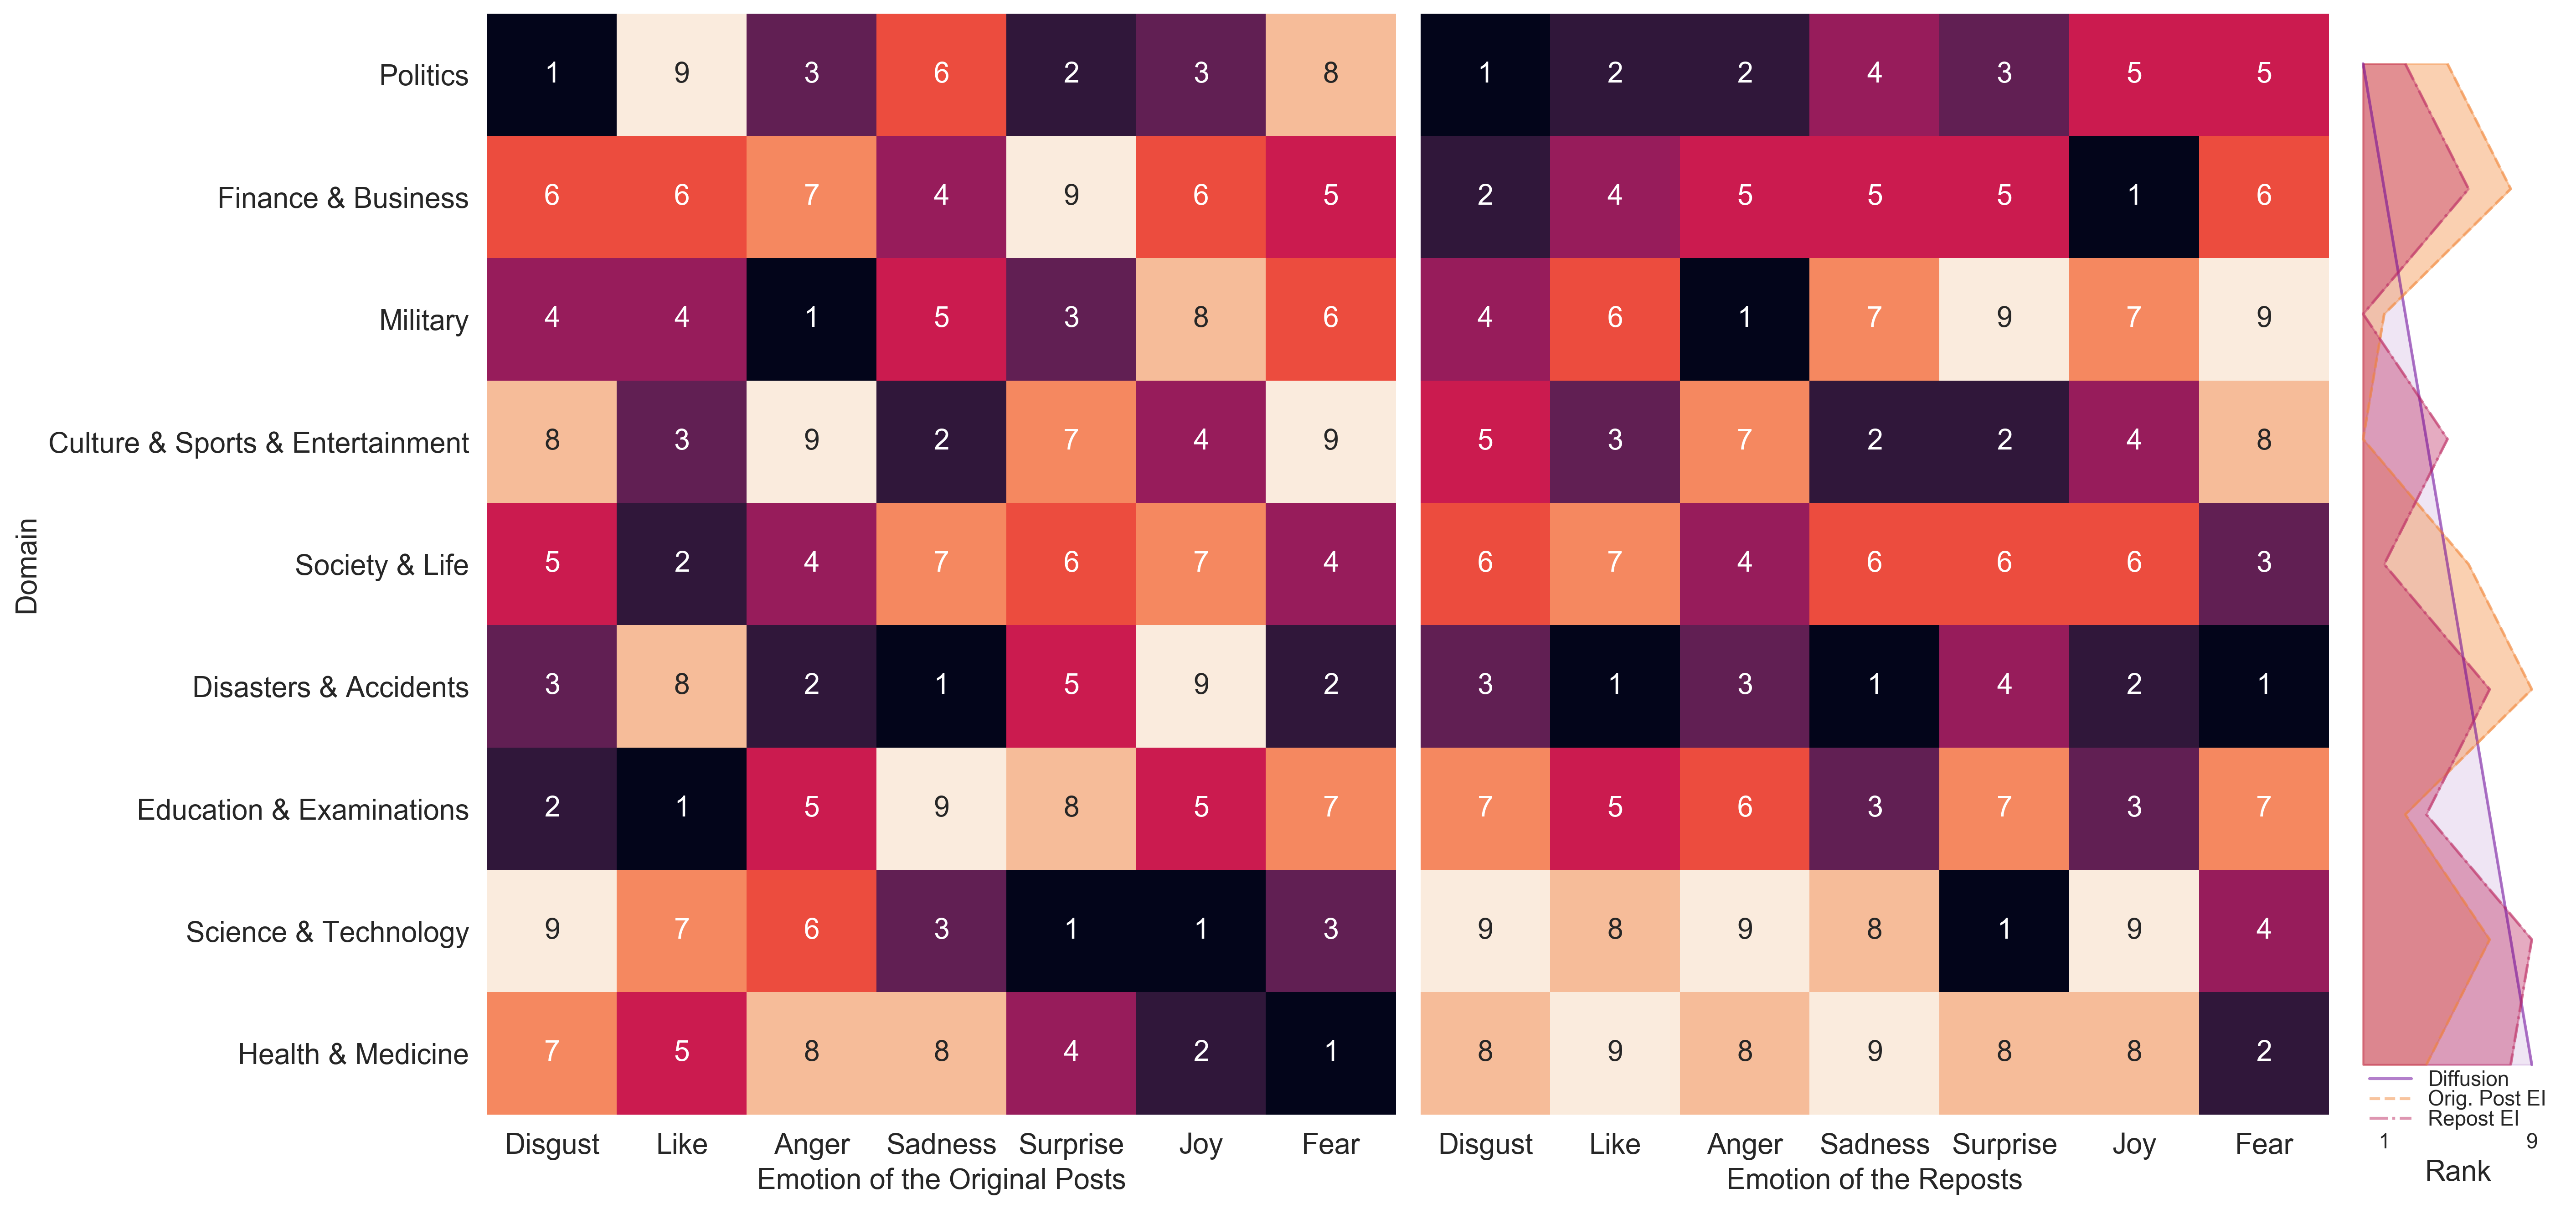

In [164]:
# Fig. 5 Plot
fig = plt.figure(tight_layout=True, figsize=(19,9))
gs = gridspec.GridSpec(1,9)

# subplot 1 (Left)
ax = fig.add_subplot(gs[0,0:4])
orig_post_emo_rank_ht = sns.heatmap(data=orig_post_emo_rank, cbar=False, annot=True, annot_kws={"size": 15})


orig_post_emo_rank_ht.set_xlabel("Emotion of the Original Posts", fontsize = 15)
orig_post_emo_rank_ht.set_ylabel("Domain", fontsize = 15)
orig_post_emo_rank_ht.set_xticklabels(orig_post_emo_rank_ht.get_xticklabels(), fontsize = 15)
orig_post_emo_rank_ht.set_yticklabels(orig_post_emo_rank_ht.get_yticklabels(), fontsize = 15)

# subplot 2 (Middle)
ax = fig.add_subplot(gs[0,4:8])
repost_emo_rank_ht = sns.heatmap(data=repost_emo_rank, cbar=False, annot=True, annot_kws={"size": 15})

repost_emo_rank_ht.set_xlabel("Emotion of the Reposts", fontsize = 15)
repost_emo_rank_ht.set_xticklabels(repost_emo_rank_ht.get_xticklabels(), fontsize = 15)
repost_emo_rank_ht.set_yticklabels([])

# subplot 3 (Right)
ax = fig.add_subplot(gs[0,8])
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg_around(3.5, 4.5, 270)
# ax = axes[2]
line_diffusion = ax.plot(range(9), color='#690098', alpha=.5, transform = rot + base)
ax.fill_between(x = range(0,9,1), y1 = range(9), color='#690098',
                alpha=.1, transform = rot + base)

line_orig_post = ax.plot(np.array(orig_post_emo_int_rank) - 1, '--', color='#F38A3E', alpha=.5, transform = rot + base)
ax.fill_between(x = range(0,9,1), y1 = np.array(orig_post_emo_int_rank) - 1, color='#F38A3E',
                alpha=.4, transform = rot + base)

line_repost = ax.plot(np.array(repost_emo_int_rank) - 1, '-.', color='#BE2F65', alpha=.5, transform = rot + base)
ax.fill_between(x = range(0,9,1), y1 = np.array(repost_emo_int_rank) - 1, color='#BE2F65',
                alpha=.4, transform = rot + base)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(['Diffusion', 'Orig. Post EI', 'Repost EI'], 
           bbox_to_anchor=(0.5, 0.04),loc='upper center', borderaxespad=0,
           frameon=False, labelspacing=-0.01, borderpad=0)
plt.xticks([0, 7], ( '1','9'))
plt.xlabel('Rank', fontsize=15)
plt.yticks([])


plt.savefig('./figs/fig_5.pdf', bbox_inches='tight', format='pdf')


## User Behaviors (Table 8~10)

### Number of Reposts for Reply (Table 8)

In [165]:
reply_dist = {domain:[] for domain in ordered_domains}
reply_dist['Total'] = []

for og in og_coll.find({'gotForward':{'$gt':0}}):
    reply_dist[og['domain']].append(og['replyCnt'])
    reply_dist['Total'].append(og['replyCnt'])
    
data_stat = []
for k, v in reply_dist.items():
    data_stat.append({
        'Domain': k,
        'Mean': np.average(v),
        'Standard Error': np.std(v)
    })
data_stat = pd.DataFrame(data_stat)
data_stat = data_stat[['Domain', 'Mean', 'Standard Error']]
data_stat

Domain      Mean  Standard Error
0                          Politics  1.799465        6.984186
1                Finance & Business  1.067343        5.569178
2                          Military  1.880597        9.347795
3  Culture & Sports & Entertainment  0.964729        5.444938
4                    Society & Life  0.847235        5.032453
5             Disasters & Accidents  0.458298        2.846978
6          Education & Examinations  0.423181        3.036641
7              Science & Technology  0.259036        1.494692
8                 Health & Medicine  0.492715        3.071634
9                             Total  0.792845        4.688530

### Cascade Concentration (Table 8)

In [166]:
cc_dist = {domain:[] for domain in ordered_domains}
cc_dist['Total'] = []

for og in og_coll.find({}):
    cc_dist[og['domain']].append(og['concentration'])
    cc_dist['Total'].append(og['concentration'])
    
data_stat = []
for k, v in cc_dist.items():
    data_stat.append({
        'Domain': k,
        'Mean': np.average(v) * 100.0
    })
data_stat = pd.DataFrame(data_stat)
data_stat = data_stat[['Domain', 'Mean']]
data_stat

Domain      Mean
0                          Politics  2.602312
1                Finance & Business  2.044211
2                          Military  2.571913
3  Culture & Sports & Entertainment  1.937643
4                    Society & Life  2.002257
5             Disasters & Accidents  2.037788
6          Education & Examinations  2.226460
7              Science & Technology  1.200628
8                 Health & Medicine  1.559707
9                             Total  1.946903

### Starter Engagement (Table 9)

In [167]:
se_dist = {domain:[] for domain in ordered_domains}

for og in og_coll.find({'gotForward':{'$gt':0}}):
    se_dist[og['domain']].append(og['starterRepostCnt'] + 1)

se_ints = {domain:0  for domain in ordered_domains}
for domain, se in se_dist.items():
    total=float(len(se))
    xf = []
    pf = []
    se.sort()
    counts = list(set(se))
    counts.sort()
    for d in counts:
        ind = se.index(d)
        count = len(se[ind:])
        p = (count / float(total)) * 100
        xf.append(d) 
        pf.append(p)
    se_ints[domain] = get_int(xf, pf)
    
normed_se_ints = {domain : (se_ints[domain] / max(se_ints.values())) 
                  for domain in ordered_domains}
values = list(normed_se_ints.values())
values.sort(reverse=True)
rank_se_ints = {k : (int(values.index(v)) + 1) for k, v in normed_se_ints.items()}

data_stat = {}
for k, v in se_dist.items():
    l = len(se_dist[k])
    data_stat[k]={
        'Mean': np.average(v),
        'Standard Error': np.std(v),
        'Min': np.min(v),
        'Median': int(np.median(v)),
        'Max': np.max(v),
        '% of >= 2': np.sum(list(map(lambda x : x >= 2, se_dist[k]))) / l * 100.0,
        '% of >= 6': np.sum(list(map(lambda x : x >= 6, se_dist[k]))) / l * 100.0,
        '% of >= 11': np.sum(list(map(lambda x : x >= 11, se_dist[k]))) / l * 100.0,
        'NA':normed_se_ints[k], 
        'R': rank_se_ints[k],
    }
data_stat = pd.DataFrame(data_stat).T
data_stat = data_stat[['Mean', 'Standard Error', 
                       'Min', 'Median', 'Max',
                       '% of >= 2', '% of >= 6', '% of >= 11',
                       'NA', 'R']]
data_stat

Mean  Standard Error  Min  Median  \
Politics                          2.351159       12.878205  1.0     1.0   
Finance & Business                1.344678        2.269327  1.0     1.0   
Military                          1.473881        2.532488  1.0     1.0   
Culture & Sports & Entertainment  1.233834        1.317690  1.0     1.0   
Society & Life                    1.394096        3.713813  1.0     1.0   
Disasters & Accidents             1.232766        1.284221  1.0     1.0   
Education & Examinations          1.373315        3.657248  1.0     1.0   
Science & Technology              1.286145        2.224464  1.0     1.0   
Health & Medicine                 1.482561        6.691682  1.0     1.0   

                                    Max  % of >= 2  % of >= 6  % of >= 11  \
Politics                          343.0  18.894831   3.743316    1.871658   
Finance & Business                 73.0  14.265025   1.303403    0.434468   
Military                           40.0  18.656716   1.492537    0.373134   
Culture & Sports & Entertainment   35.0  12.344873   0.849118    0.195950   
Society & Life                    164.0  14.405122   1.067046    0.462387   
Disasters & Accidents              37.0  11.319149   0.765957    0.297872   
Education & Examinations          121.0  14.150943   0.808625    0.336927   
Science & Technology               44.0   8.584337   1.204819    0.451807   
Health & Medicine                 275.0  12.759382   1.456954    0.750552   

                                        NA    R  
Politics                          1.000000  1.0  
Finance & Business                0.444609  6.0  
Military                          0.516191  3.0  
Culture & Sports & Entertainment  0.371420  8.0  
Society & Life                    0.454208  5.0  
Disasters & Accidents             0.369843  9.0  
Education & Examinations          0.455969  4.0  
Science & Technology              0.412910  7.0  
Health & Medicine                 0.521256  2.0

### Starters' Reposts Content Analysis (Table S20)

In [169]:
st_repost_dist = {domain:{'Number of cascades in which starters expressed disbeliefs':0,
                         'Number of cascades that starters reposted':0} 
                   for domain in ordered_domains}
st_repost_dist['All domains'] =  \
    {'Number of cascades in which starters expressed disbeliefs':0, \
     'Number of cascades that starters reposted':0} 
column_order = ['Number of cascades in which starters expressed disbeliefs',
                'Number of cascades that starters reposted',
                'Disbelief rate',
                'Rank']

for og in og_coll.find({'starterRerpostBeliefs':{'$exists':True}}):
    st_repost_dist[og['domain']]['Number of cascades that starters reposted'] += 1
    st_repost_dist['All domains']['Number of cascades that starters reposted'] += 1
    beliefs = og['starterRerpostBeliefs']
    if 'DNB' in beliefs or 'doubt' in beliefs or 'debunk' in beliefs:
        st_repost_dist[og['domain']]['Number of cascades in which starters expressed disbeliefs'] += 1
        st_repost_dist['All domains']['Number of cascades in which starters expressed disbeliefs'] += 1

for domain in st_repost_dist.keys():
    st_repost_dist[domain]['Disbelief rate'] = \
    st_repost_dist[domain]['Number of cascades in which starters expressed disbeliefs'] / \
    st_repost_dist[domain]['Number of cascades that starters reposted']

rates = []
for domain in ordered_domains:
    rates.append(st_repost_dist[domain]['Disbelief rate'])
rates.sort(reverse=True)
for domain in ordered_domains:
    st_repost_dist[domain]['Rank'] = rates.index(st_repost_dist[domain]['Disbelief rate']) + 1 

st_repost_dist = pd.DataFrame(st_repost_dist).T
st_repost_dist = st_repost_dist[column_order]
st_repost_dist


Number of cascades in which starters expressed disbeliefs  \
Politics                                                                       32.0           
Finance & Business                                                             55.0           
Military                                                                        9.0           
Culture & Sports & Entertainment                                               69.0           
Society & Life                                                                216.0           
Disasters & Accidents                                                         107.0           
Education & Examinations                                                       90.0           
Science & Technology                                                           10.0           
Health & Medicine                                                              79.0           
All domains                                                                   667.0           

                                  Number of cascades that starters reposted  \
Politics                                                              212.0   
Finance & Business                                                    197.0   
Military                                                               50.0   
Culture & Sports & Entertainment                                      189.0   
Society & Life                                                        810.0   
Disasters & Accidents                                                 266.0   
Education & Examinations                                              210.0   
Science & Technology                                                   57.0   
Health & Medicine                                                     289.0   
All domains                                                          2280.0   

                                  Disbelief rate  Rank  
Politics                                0.150943   9.0  
Finance & Business                      0.279188   4.0  
Military                                0.180000   7.0  
Culture & Sports & Entertainment        0.365079   3.0  
Society & Life                          0.266667   6.0  
Disasters & Accidents                   0.402256   2.0  
Education & Examinations                0.428571   1.0  
Science & Technology                    0.175439   8.0  
Health & Medicine                       0.273356   5.0  
All domains                             0.292544   NaN